# Titanic

#### 25/10/2023

* **1. Importing libriaries.**
* **2. Loading data and preprocessing.**
    * 2.1 Load data.
    * 2.2 Data dictionary.
    * 2.3 Outlier detection and removal.
* **3. Exploratory Data Analysis (EDA).**
    * 3.1 Explore data.
    * 3.2 Checking data for duplicates, null and missing values.
* **4. Feature analysis.**
        4.1 Describing features.
        4.2 Categorical values.
        4.3 Numerical values.
* **5. Data preprocesing**
    * 5.1 Concatenating train and test set
    * 5.2 Filling missing Values

* **6 Feature engineering**
    * 6.1 Name/Title
    * 6.2 Cabin
    * 6.3 Age/Pclass
    * 6.4 Family Size
* **7 Modeling**
    * 7.1 Encoding features.
    
* 6.3 Applying ML models with evaluation (score, f1, precision, recall).
    * Logistic Regression.
    * SVC Support Vector Machines.
    * Linear SVC.
    * SGD - Stochastic Gradient Decent.
    * K- Nearest Neigbours.
    * GNB - Gaussian Naive Base.
    * Perceptron.
    * DTC - Decision Tree CLassifier.
    * RF - Random Forest (ensable method).
    * Catboost.
    * Adaboost.
* 6.4 Compering all models & chosing the best performing one.
* 6.5 One more look at features, engineered features, Ticket, trying new features and reload models.
* 6.6 Creating a pipeline with selected models, applying PCA, Select-K features, hyperparameter tuning and cross validation.
    * 6.1 Simple modeling
        * 6.1.1 Cross validate models
        * 6.1.2 Hyperparamater tunning for best models
        * 6.1.3 Plot learning curves
        * 6.1.4 Feature importance of the tree based classifiers
    * 6.2 Ensemble modeling
        * 6.2.1 Combining models
    * 6.3 Prediction
        * 6.3.1 Predict and Submit results

### 1. Importing libraries.

In [1]:
import pandas as pd
import numpy as np
import missingno
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')


##### 2.1 Loading data.

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
testId = test.PassengerId
submission = pd.read_csv('gender_submission.csv')

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


##### 2.2  Data Dictionary:

* Survival: 0 = No, 1 = Yes
* Pclass: Ticket class 1 = 1st, 2 = 2nd  3 = rd
* SibSp: # of siblings / spouses aboard the Titanic
* Parch: # of parents / children aboard the Titanic
* Ticket: Ticket number
* Fare: Passenger fare
* Cabin: Cabin numer
* Age: Age in years 
* Sex: Sex of the passengers
* Embarked: Port of Embarkation C = Cherbourg, Q = Queenstown, S = Southampton

##### 2.3 Outlier detection.

In [6]:
def detect_outliers(df, n, features):
    outlier_indices = []
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(key for key, value in outlier_indices.items() if value > n)
    return multiple_outliers

outliers = detect_outliers(train, 2, ['Age', 'SibSp', 'Parch', 'Fare'])

In [7]:
outliers

[27, 88, 159, 180, 201, 324, 341, 792, 846, 863]

In [8]:
print(len(train))
train = train.drop(outliers, axis=0).reset_index(drop=True)
len(train)

891


881

### 3. Exploratory Data Analysis (EDA)


#### 3.1 Exploring the data.

In [9]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


In [12]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


In [13]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


#### 3.2 Checking data for duplicates null and missing values.

In [14]:
train.duplicated().sum()

0

In [15]:
train.duplicated(subset=['Name'])

0      False
1      False
2      False
3      False
4      False
       ...  
876    False
877    False
878    False
879    False
880    False
Length: 881, dtype: bool

In [16]:
train.isnull().sum().sort_values(ascending=False)

Cabin          680
Age            170
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
dtype: int64

In [17]:
test.isnull().sum().sort_values(ascending=False)

Cabin          327
Age             86
Fare             1
PassengerId      0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Embarked         0
dtype: int64

<Axes: >

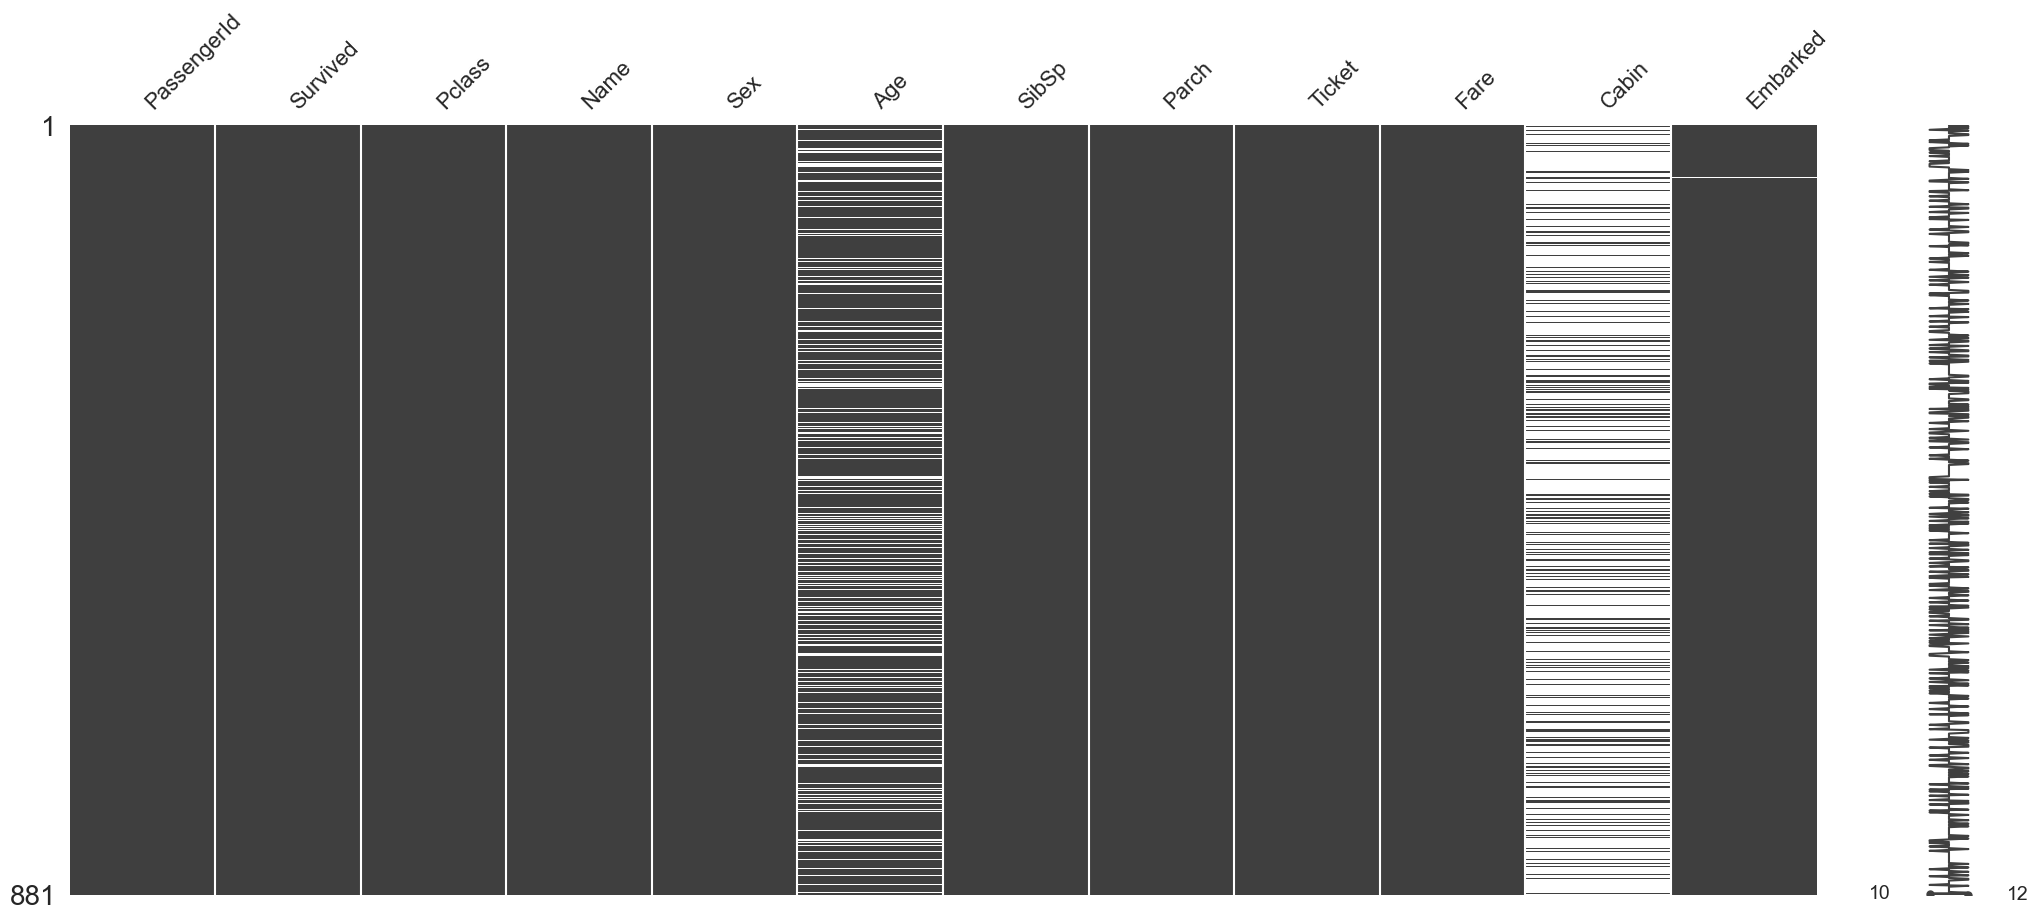

In [18]:
missingno.matrix(train)

<Axes: >

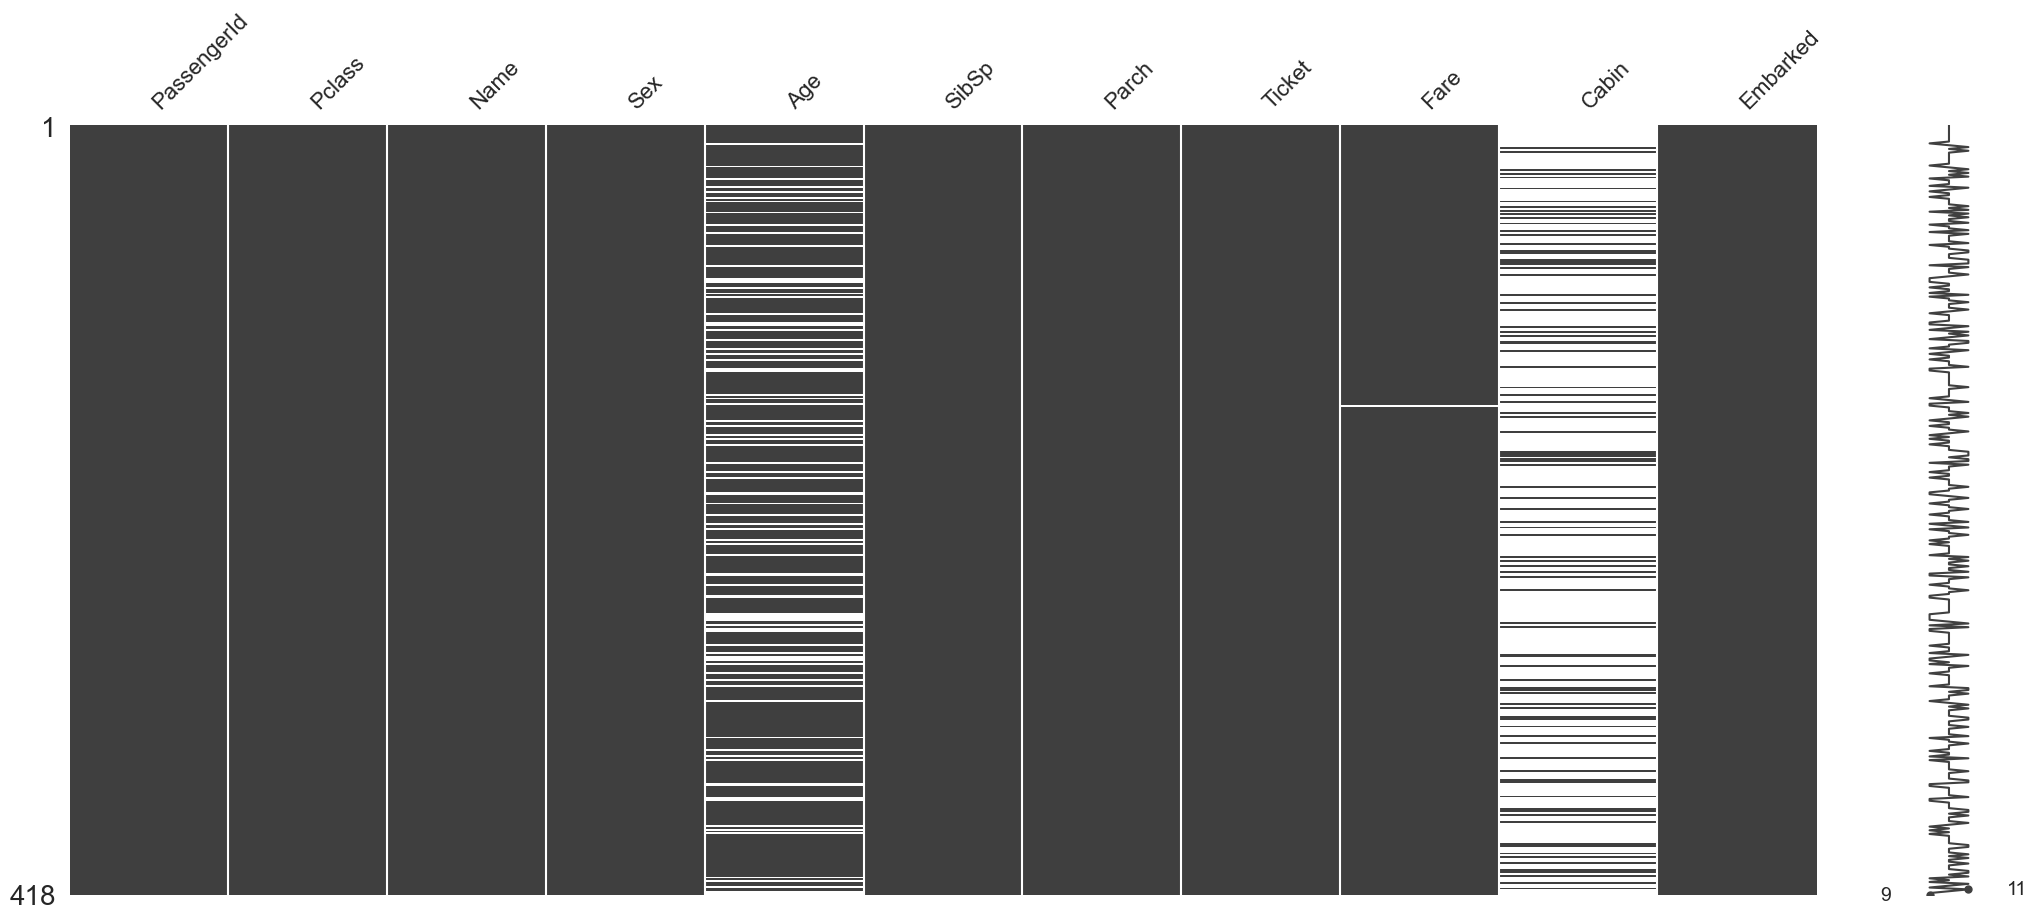

In [19]:
missingno.matrix(test)

<Axes: >

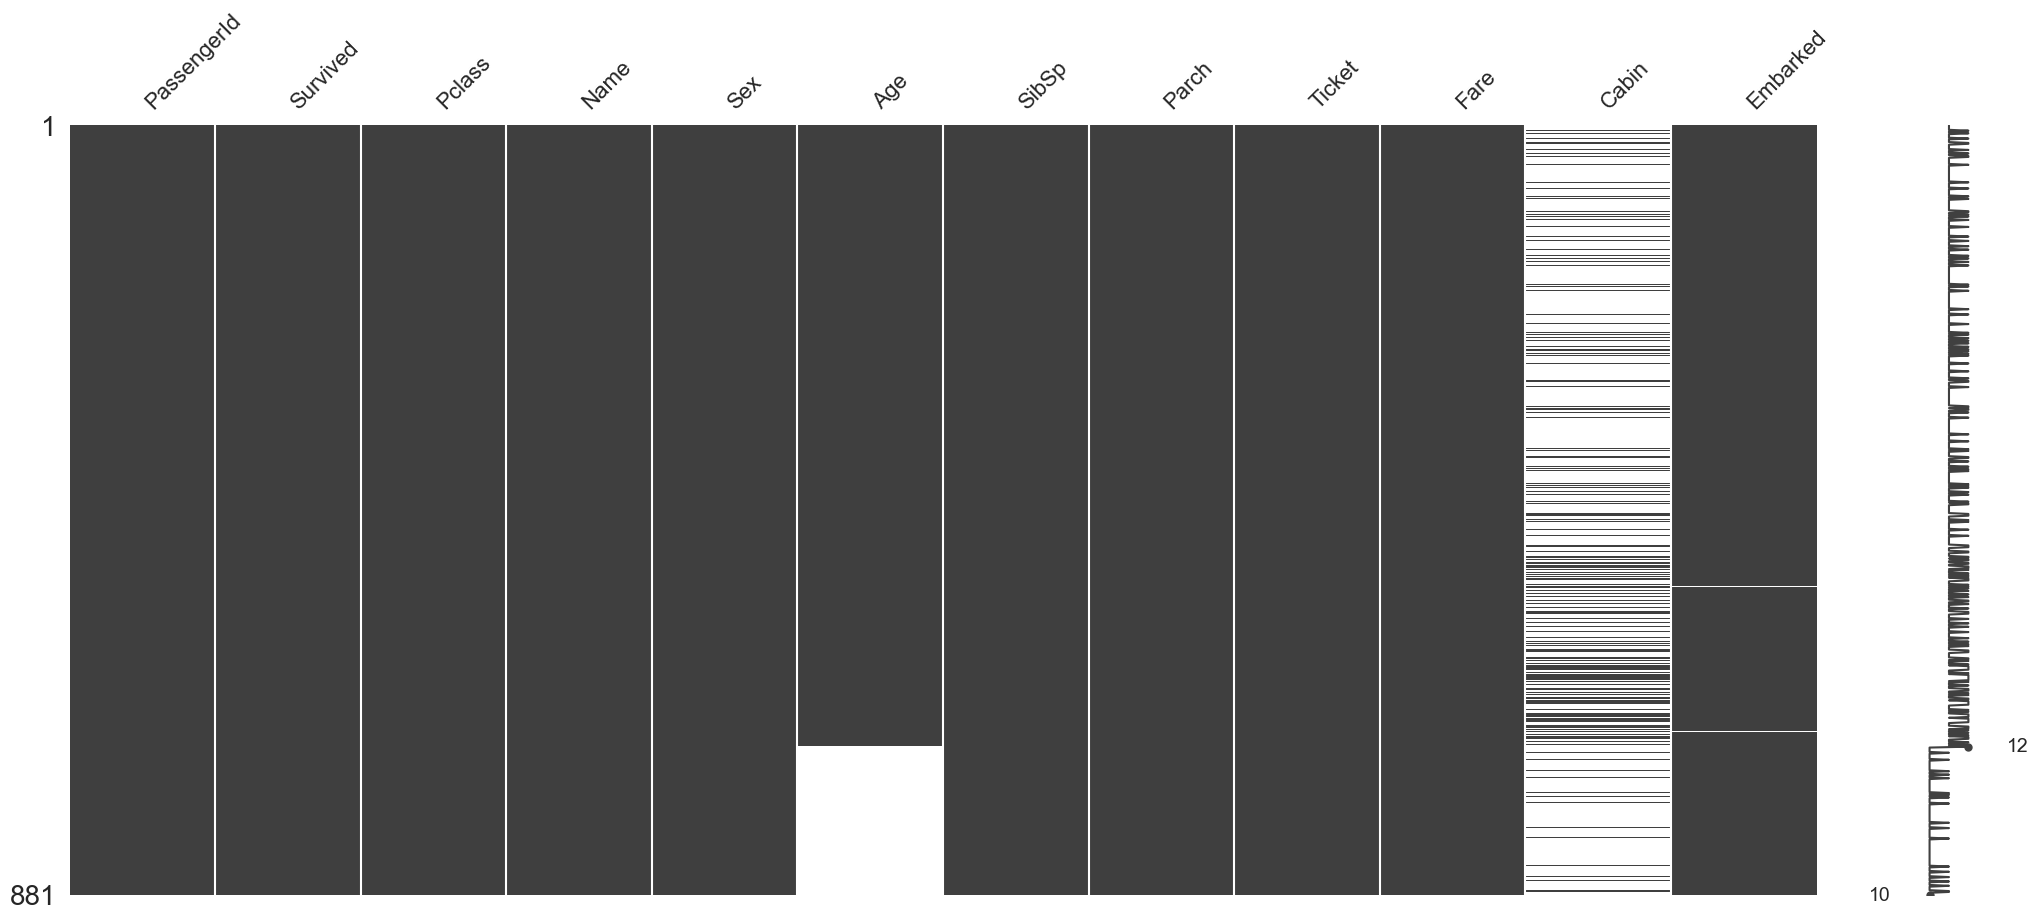

In [20]:
sorted = train.sort_values('Age')
missingno.matrix(sorted)

### 4. Feature analysis.

#### 4.1 Describing features.

** 4.2 Categorical:**
- **Nominal**(variables that have two or more categories, but which do not have an intrinsic order.)
   > - **Cabin**
   > - **Embarked**(Port of Embarkation)
            C(Cherbourg)
            Q(Queenstown) 
            S(Southampton)
        
- **Dichotomous**(Nominal variable with only two categories)
   > - **Sex**
            Female
            Male
- **Ordinal**(variables that have two or more categories just like nominal variables. Only the categories can also be ordered or ranked.)
   > - **Pclass** (A proxy for socio-economic status (SES)) 
            1(Upper)
            2(Middle) 
            4.3  3(Lower)
***
**Numeric:**
- **Discrete**
  >  - **Passenger ID**(Unique identifing # for each passenger)
  >  - **SibSp**
  >  - **Parch**
  >  - **Survived** (Our outcome or dependent variable)
            0
            1
- **Continous**
>  - *4.4 *Age**
>  - **Fare**
***
**Text Variable**
> - **Ticket** > -cket number for passenger.)
> - **
***
**4.5 Feature Relationships.**
> -
***
**4.6 Ask Questions about the data.**
> -
***ame**(  Name of the passenger.) 

#### 4.2 Categorical features

* 4.2.1 Cabin
* 4.2.2 Point of Embarkation
* 4.2.3 Sex
* 4.2.1 Pclass

##### 4.2.1 Cabin

In [21]:
train['Cabin'] = train['Cabin'].astype(str)
test['Cabin'] = test['Cabin'].astype(str)


In [22]:
train.query('Cabin.notnull()').groupby('Cabin')['Survived'].mean()

Cabin
A10    0.000000
A14    0.000000
A16    1.000000
A19    0.000000
A20    1.000000
         ...   
F38    0.000000
F4     1.000000
G6     0.500000
T      0.000000
nan    0.302941
Name: Survived, Length: 148, dtype: float64

##### 4.2.2 Point of Embarkation

In [23]:
train.Embarked.value_counts()

Embarked
S    634
C    168
Q     77
Name: count, dtype: int64

In [24]:
train.Embarked.isnull().sum()

2

In [25]:
train.groupby('Embarked')['Survived'].mean()

Embarked
C    0.553571
Q    0.389610
S    0.339117
Name: Survived, dtype: float64

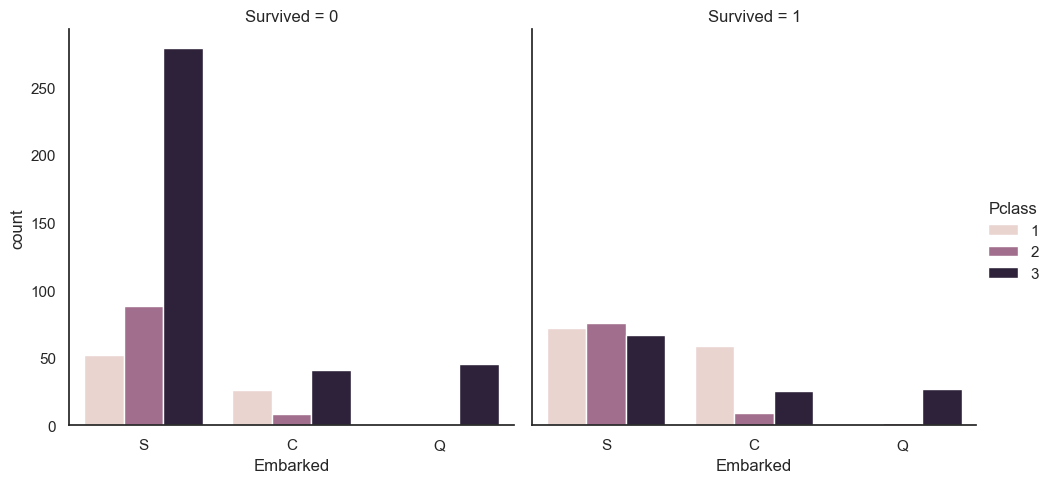

In [26]:
sns.catplot(data=train, x='Embarked', col='Survived', hue='Pclass' , kind='count' )

##### 4.2.3 Sex

In [27]:
train.Sex.isnull().sum()

0

In [28]:
survival_by_sex = train.groupby('Sex')['Survived'].mean()
survival_by_sex

Sex
female    0.747573
male      0.190559
Name: Survived, dtype: float64

<Axes: xlabel='Sex', ylabel='Survived'>

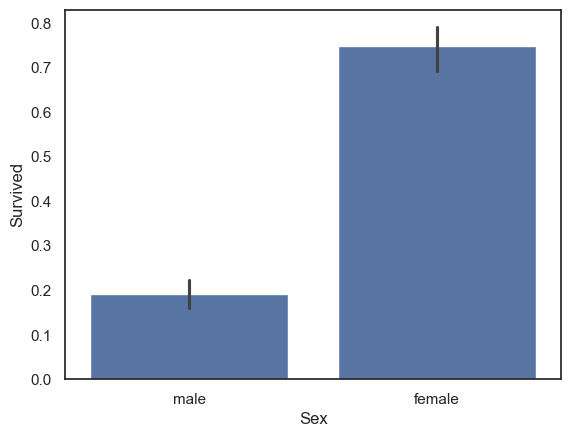

In [29]:
sns.barplot(data=train, x='Sex', y='Survived')

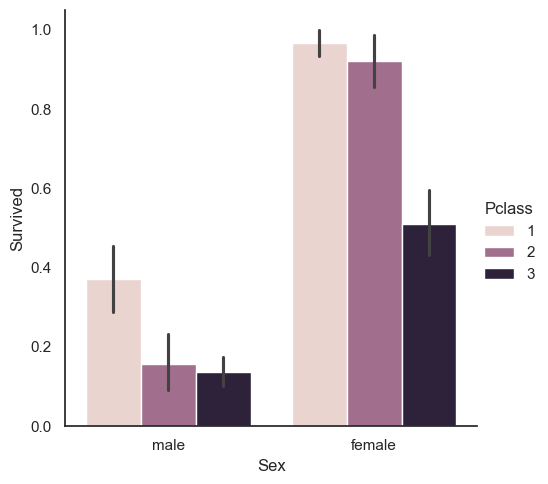

In [30]:
sns.catplot(data=train, x='Sex', y='Survived', hue='Pclass', kind='bar')

##### 4.2.4 Pclass

In [31]:
train.Pclass.value_counts()

Pclass
3    484
1    213
2    184
Name: count, dtype: int64

In [32]:
train[['Parch','SibSp','Age','Pclass','Survived']].groupby('Pclass').mean().sort_values('Survived', ascending=False)

,Parch,SibSp,Age,Survived
Pclass,,,,
1,0.333333,0.380282,38.499563,0.629108
2,0.380435,0.402174,29.877630,0.472826
3,0.369835,0.508264,25.140620,0.245868


In [33]:
Pclass_sur_mean = train.groupby('Pclass')['Survived'].mean()
Pclass_sur_mean

Pclass
1    0.629108
2    0.472826
3    0.245868
Name: Survived, dtype: float64

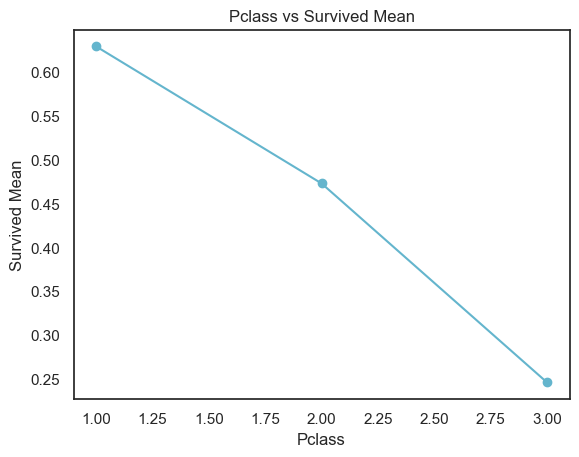

In [34]:
Pclass_sur_mean.plot(marker='o', linestyle='-', color='c')
plt.title('Pclass vs Survived Mean')
plt.xlabel('Pclass')
plt.ylabel('Survived Mean')

plt.show()

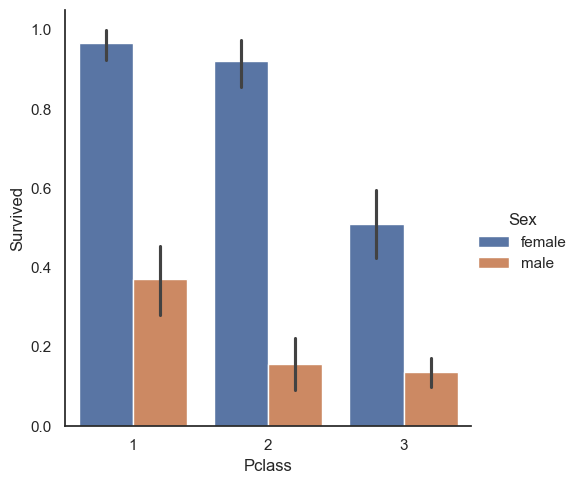

In [35]:
sns.catplot(data=train, x='Pclass', y='Survived', hue='Sex', kind='bar')

In [36]:
train[['Pclass', 'Sex']].groupby(['Pclass', 'Sex']).size().unstack(fill_value=0)

Sex,female,male
Pclass,,
1,92,121
2,76,108
3,141,343


In [37]:
men = train.query('Sex == "male"')['Survived']
men_ratio = sum(men) / len(men)
men_ratio

0.19055944055944055

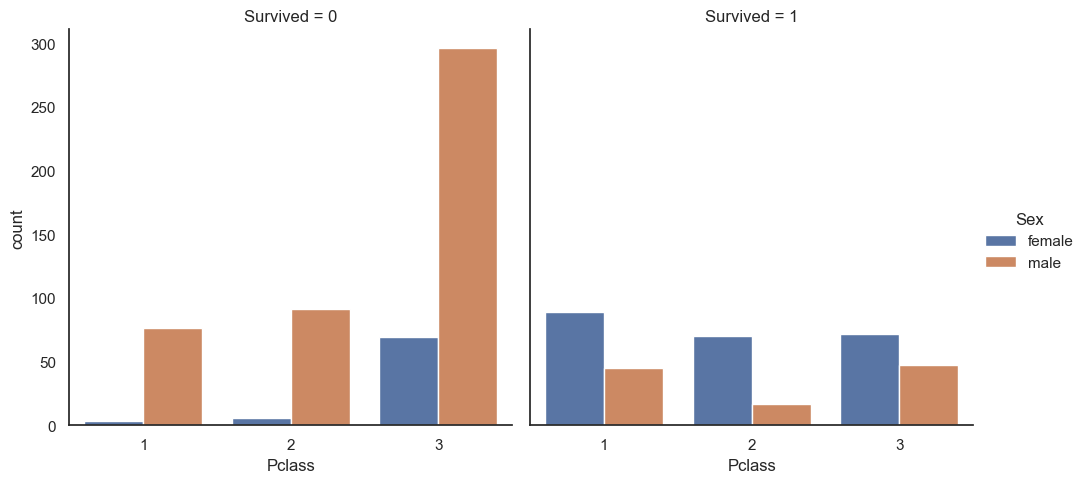

In [38]:
sns.catplot(data=train, x='Pclass', col='Survived', hue='Sex', kind='count')

#### 4.3 Numerical features.
* 4.3.1 Pearson corelation matrix.
* 4.3.2 Age
* 4.3.3 SibSp
* 4.3.4 Parch
* 4.3.5 Fare

##### 4.3.1 Pearson corelation matrix.

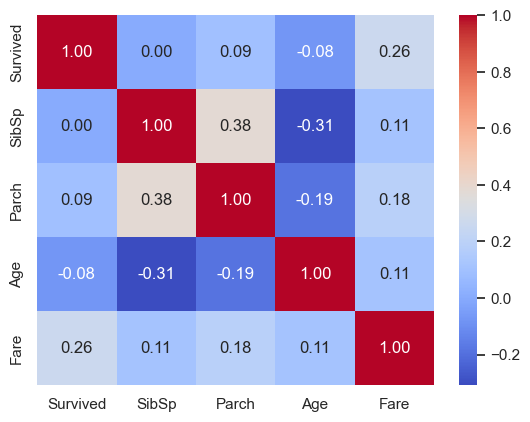

In [39]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived 
g = sns.heatmap(train[["Survived","SibSp","Parch","Age","Fare"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

##### 4.3.2 Age.

In [40]:
train.Age.isnull().sum()

170

In [41]:
# ax = train.Age.plot(kind='hist', bins=20, title='Histogram of Age')

# ax.set_xlabel('')
# ax.set_ylabel('')

In [42]:
# ax = train.Age.plot(kind='kde', bins=20, title='Histogram of Age')

# ax.set_xlabel('')
# ax.set_ylabel('')

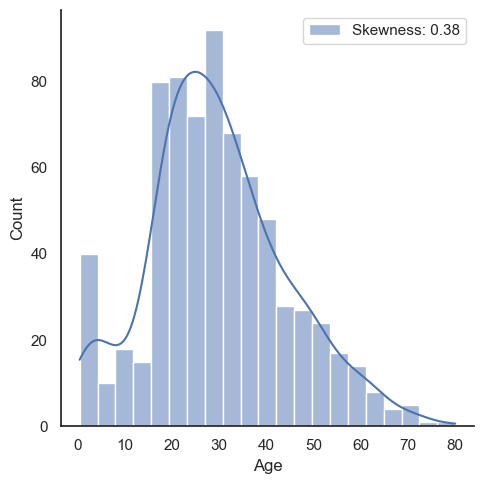

In [43]:
sns.displot(data=train, x='Age', kde=True, label='Skewness: %.2f'%(train['Age'].skew()))
plt.legend(loc='best')

In [44]:
train.groupby('Age')['Survived'].mean()

Age
0.42     1.0
0.67     1.0
0.75     1.0
0.83     1.0
0.92     1.0
        ... 
70.00    0.0
70.50    0.0
71.00    0.0
74.00    0.0
80.00    1.0
Name: Survived, Length: 88, dtype: float64

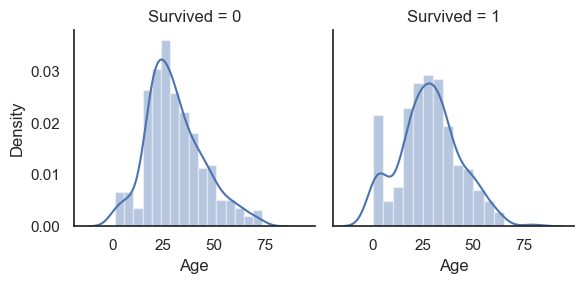

In [45]:
g = sns.FacetGrid(train, col='Survived')

g.map(sns.distplot, 'Age')

##### 4.3.3 SibSp.

In [46]:
train.SibSp.value_counts(dropna=False)

SibSp
0    608
1    209
2     28
4     18
3     13
5      5
Name: count, dtype: int64

Text(0, 0.5, 'Count')

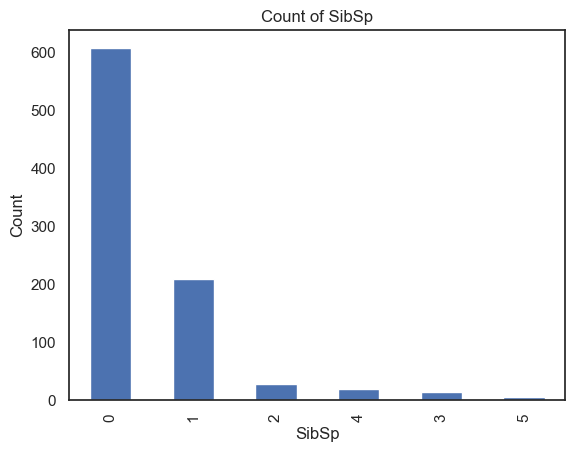

In [47]:
ax = train.SibSp.value_counts(dropna=False) \
.plot(kind='bar', title='Count of SibSp')
ax.set_xlabel('SibSp')
ax.set_ylabel('Count')

In [48]:
train.SibSp.isnull().sum()

0

In [49]:
train.groupby('SibSp')['Survived'].mean()

SibSp
0    0.345395
1    0.535885
2    0.464286
3    0.153846
4    0.166667
5    0.000000
Name: Survived, dtype: float64

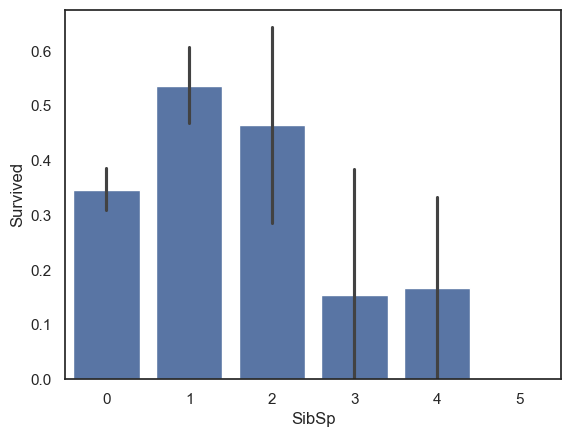

In [50]:
sns.barplot(data=train, x='SibSp', y='Survived')
plt.show()

#### 4.3.4 Parch.

In [51]:
train.Parch.value_counts(dropna=False)

Parch
0    678
1    118
2     70
5      5
3      5
4      4
6      1
Name: count, dtype: int64

In [52]:
train.Parch.isnull().sum()

0

In [53]:
train.groupby('Parch')['Survived'].mean()

Parch
0    0.343658
1    0.550847
2    0.542857
3    0.600000
4    0.000000
5    0.200000
6    0.000000
Name: Survived, dtype: float64

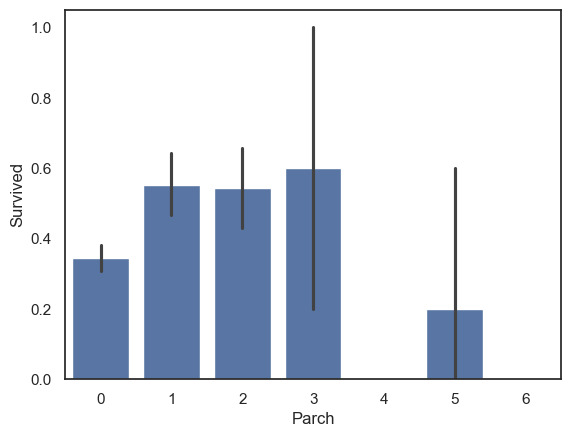

In [54]:
sns.barplot(data=train, x='Parch', y='Survived')
plt.show()

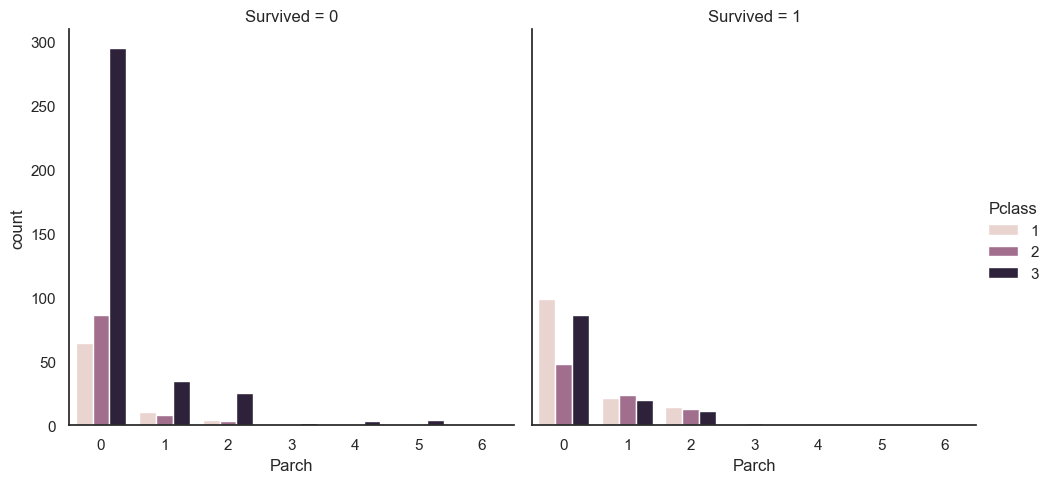

In [55]:
sns.catplot(data=train, x='Parch', col='Survived', hue='Pclass', kind='count')

##### 4.3.5 Fare

In [56]:
print('Highest Fare was:',train['Fare'].max())
print('Lowest Fare was:',train['Fare'].min())
print('Average Fare was:',train['Fare'].mean())

Highest Fare was: 512.3292
Lowest Fare was: 0.0
Average Fare was: 31.121565607264476


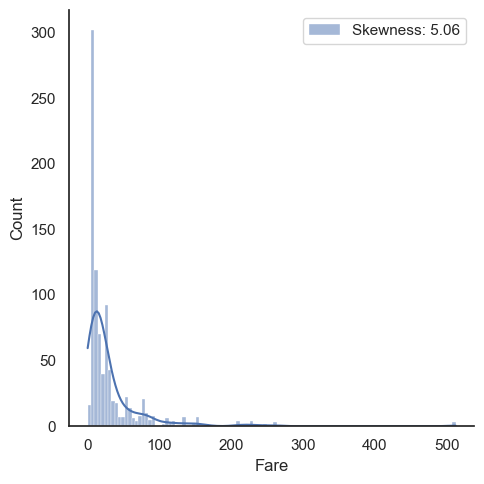

In [57]:
sns.displot(data=train, x='Fare', kde='True', label='Skewness: %.2f'%(train['Fare'].skew()))
plt.legend(loc='best')

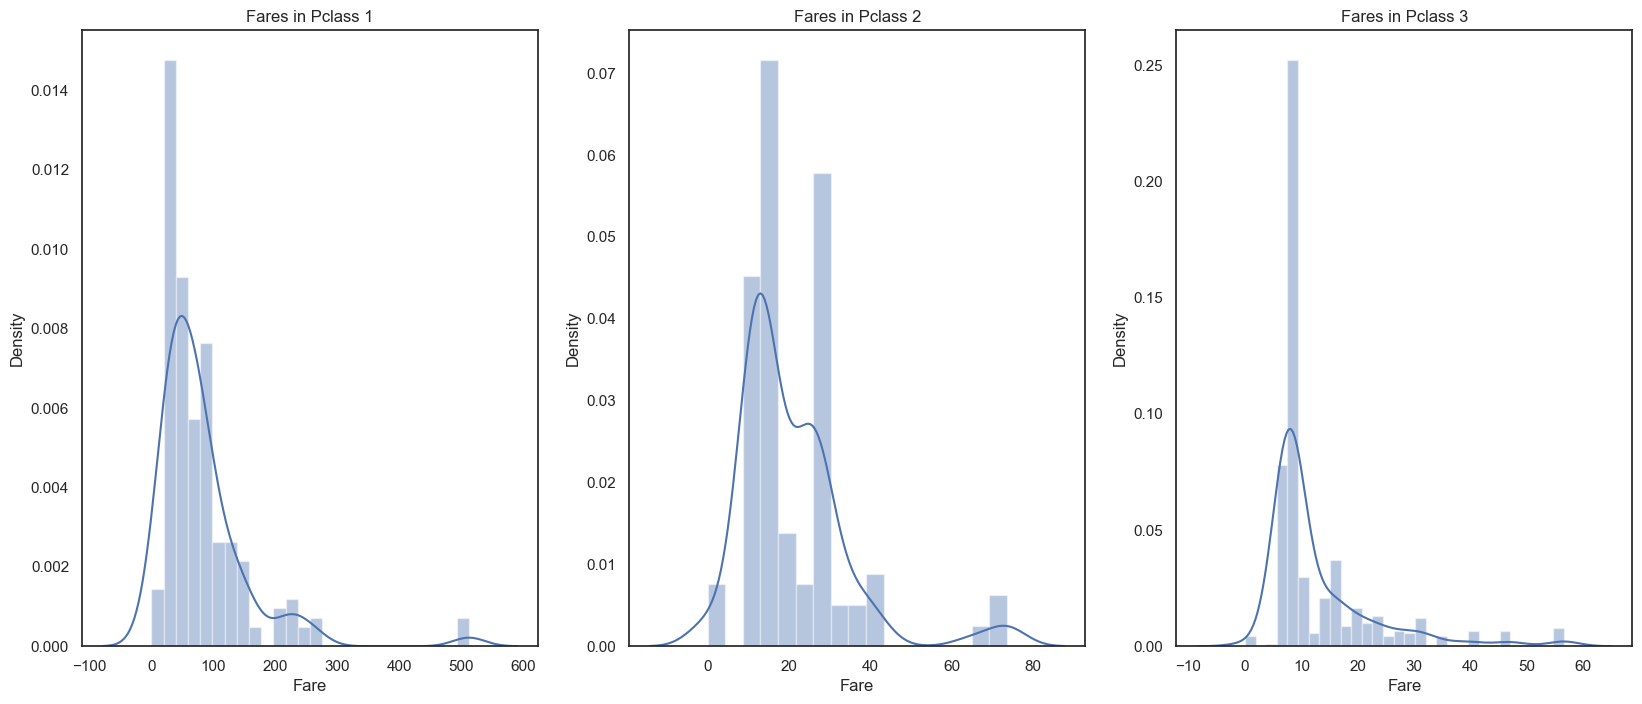

In [58]:
f,ax=plt.subplots(1,3,figsize=(20,8))
sns.distplot(train[train['Pclass']==1].Fare,ax=ax[0])
ax[0].set_title('Fares in Pclass 1')
sns.distplot(train[train['Pclass']==2].Fare,ax=ax[1])
ax[1].set_title('Fares in Pclass 2')
sns.distplot(train[train['Pclass']==3].Fare,ax=ax[2])
ax[2].set_title('Fares in Pclass 3')
plt.show()

#### 4.5 Feature Relationships.

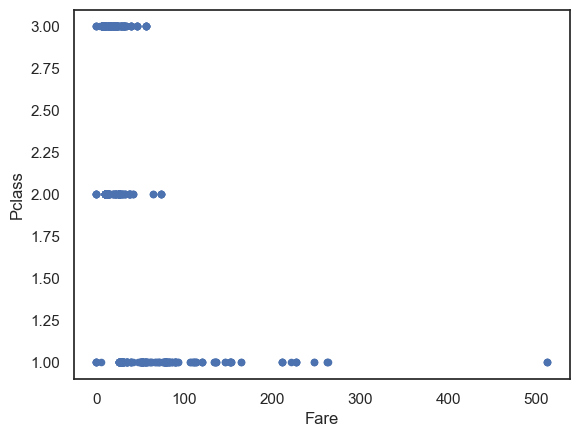

In [59]:
train.plot(kind='scatter', x='Fare', y='Pclass')
plt.show()

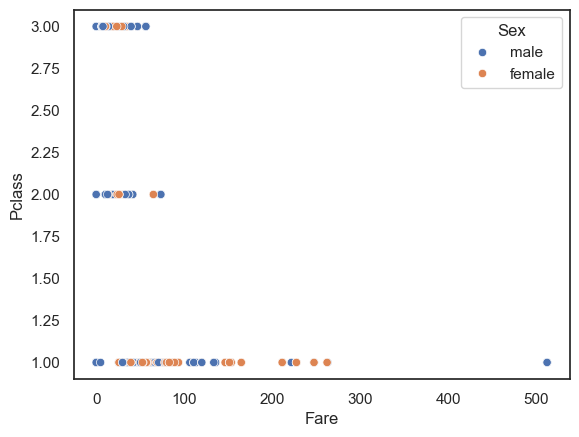

In [60]:
sns.scatterplot(x='Fare', y='Pclass',hue='Sex', data=train)

plt.show()



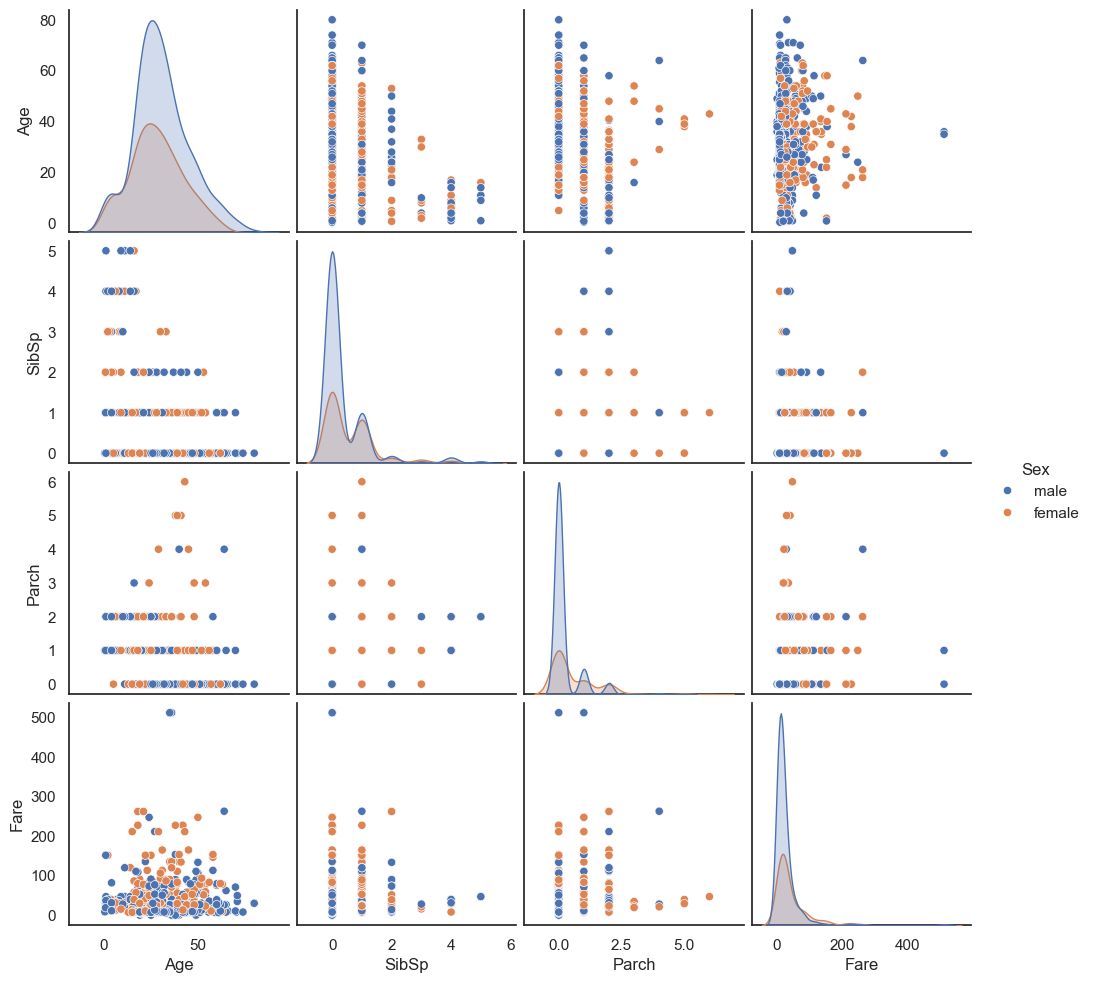

In [61]:
sns.pairplot(train, vars=['Age', 'SibSp', 'Parch', 'Fare'],
            hue='Sex')
plt.show()

In [62]:
train[['Age', 'SibSp', 'Parch', 'Fare']].dropna().corr()

,Age,SibSp,Parch,Fare
Age,1.000000,-0.307129,-0.186457,0.110219
SibSp,-0.307129,1.000000,0.371317,0.094749
Parch,-0.186457,0.371317,1.000000,0.180072
Fare,0.110219,0.094749,0.180072,1.000000


#### 5.4 Ask Questions about the data.
* Try to post and answer a question you have about the data using plot or statistic.
* Find the mean age of all women from all classes.

In [63]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,nan,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,nan,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,nan,S


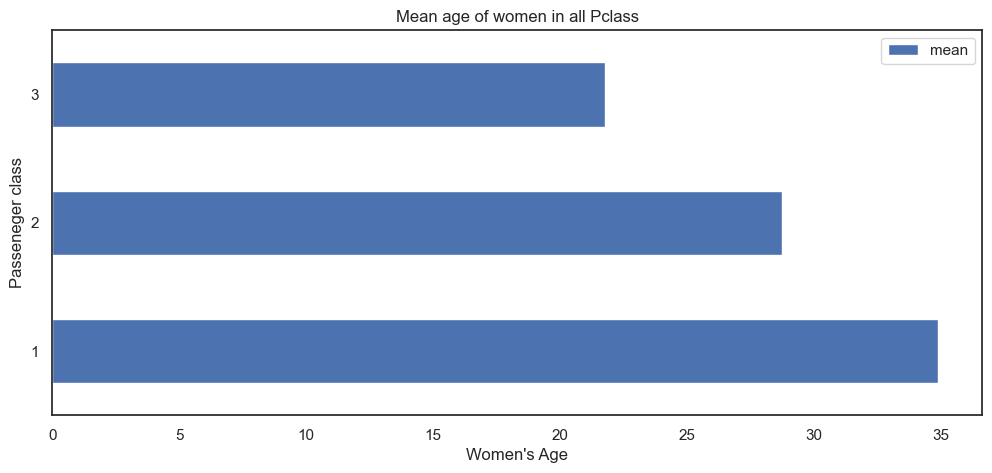

In [64]:
ax = train.query('Sex=="female"') \
.groupby('Pclass')['Age'] \
.agg(['mean']) \
.sort_values('mean', ascending=False) \
.plot(kind='barh', figsize=(12,5), title='Mean age of women in all Pclass')
ax.set_xlabel("Women's Age")
ax.set_ylabel('Passeneger class')
plt.show()

### 5. Data preprocesing
Data preprocesing is the process of getting our dataset ready for model training.
In this section we will perform the following preprocessing steps:
* 5.1 Concatenating train and test set
* 5.2 Drop and fill missing va in train and test datasets.
*      5.2.1 Embarked.
*      5.2.2 Fare.
*      5.2.3 Age.


#### 5.1 Concatenating train and test set.

In [65]:
combine = pd.concat([train,test], axis=0).reset_index(drop=True)

#### 5.2 Drop and fill missing va in train and test datasets.

##### 5.2.1 Embarked.

In [66]:
pd.crosstab([combine.Embarked,combine.Pclass],[combine.Sex,combine.Survived],margins=True).style.background_gradient(cmap='summer_r')

In [67]:
mode = combine.Embarked.dropna().mode()[0]
mode

'S'

In [68]:
combine['Embarked'] = combine.Embarked.fillna(mode)

##### 5.2.2 Fare.

In [69]:
combine.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()

Pclass  Parch  SibSp
1       0      0         31.33960
               1         75.25000
               2         51.47920
        1      0         63.35830
               1         83.15830
        2      0         83.15830
               1        120.00000
               2        262.37500
               3        263.00000
        3      1        262.37500
        4      1        263.00000
2       0      0         13.00000
               1         26.00000
               2         73.50000
               3         21.00000
        1      0         23.00000
               1         26.25000
               2         33.00000
        2      0         26.25000
               1         41.57920
        3      0         39.00000
               1         23.00000
               2         18.75000
3       0      0          7.85420
               1         14.45625
               2         19.83960
               3         16.92500
        1      0         12.47500
               1         15

In [70]:
med_fare = combine.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
combine['Fare'] = combine['Fare'].fillna(med_fare)

##### 5.2.3 Age.

In [71]:
age_by_pclass_sex = combine.groupby(['Sex', 'Pclass'])['Age'].mean()
age_by_pclass_sex

Sex     Pclass
female  1         37.244275
        2         27.499223
        3         22.185329
male    1         41.176133
        2         30.815380
        3         25.962264
Name: Age, dtype: float64

In [72]:

age_avg = combine['Age'].mean()
age_std = combine['Age'].std()
age_null_count = combine['Age'].isnull().sum()
age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
combine['Age'][np.isnan(combine['Age'])] = age_null_random_list
combine['Age'] = combine['Age'].astype(int)



In [73]:
combine.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,nan,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,nan,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,nan,S


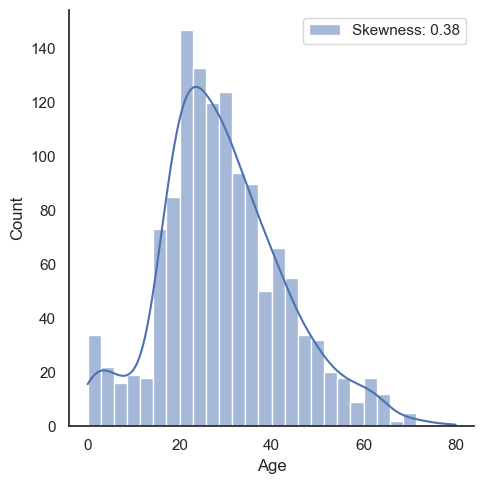

In [74]:
sns.displot(data=combine, x='Age', kde=True, label='Skewness: %.2f'%(train['Age'].skew()))
plt.legend(loc='best')

####  6. Feature engineering.
*      6.1 "Title"
*      6.2 "Cabin"
*      6.3 "Age/Pclass"
*      6.4 Family Size and Is Alone features.

#### 6.1 Title.

In [75]:
combine['Title'] = [title.split(',')[1].split('.')[0].strip() for title in combine.Name]

In [76]:
combine.Title.value_counts()

Title
Mr              753
Miss            255
Mrs             197
Master           60
Rev               8
Dr                8
Col               4
Mlle              2
Major             2
Ms                2
Lady              1
Sir               1
Mme               1
Don               1
Capt              1
the Countess      1
Jonkheer          1
Dona              1
Name: count, dtype: int64

In [77]:
# Convert to categorical values Title 
combine["Title"] = combine["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
combine["Title"] = combine["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
combine["Title"] = combine["Title"].astype(int)

In [78]:
combine.Title.value_counts()

Title
2    753
1    457
0     60
3     29
Name: count, dtype: int64

In [79]:
combine[['Title','Survived']].groupby('Title', as_index=False).mean().sort_values('Survived', ascending=False)

,Title,Survived
1,1,0.745098
0,0,0.589744
3,3,0.347826
2,2,0.157895


#### 6.2 Cabin.

In [80]:
combine.query('Cabin != "nan"  & Pclass == 3')
combine['Cabin_letter'] = combine['Cabin'].str.extract(r'([A-Za-z])')
combine['Cabin_letter'].value_counts()


Cabin_letter
n    1007
C      91
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: count, dtype: int64

In [81]:
combine.groupby('Cabin_letter')['Survived'].mean().sort_values(ascending=False)


Cabin_letter
D    0.757576
E    0.750000
B    0.744681
F    0.615385
C    0.589286
G    0.500000
A    0.466667
n    0.302941
T    0.000000
Name: Survived, dtype: float64

In [82]:
combine[['Cabin_letter', 'Sex']].groupby(['Cabin_letter', 'Sex']).size().unstack(fill_value=0)



Sex,female,male
Cabin_letter,,
A,4,18
B,36,29
C,44,47
D,23,23
E,19,22
F,8,13
G,5,0
T,0,1
n,322,685


In [83]:
    combine.Cabin.fillna('0', inplace=True)
    combine.loc[combine.Cabin.str[0] == 'A', 'Cabin'] = 1
    combine.loc[combine.Cabin.str[0] == 'B', 'Cabin'] = 2
    combine.loc[combine.Cabin.str[0] == 'C', 'Cabin'] = 3
    combine.loc[combine.Cabin.str[0] == 'D', 'Cabin'] = 4
    combine.loc[combine.Cabin.str[0] == 'E', 'Cabin'] = 5
    combine.loc[combine.Cabin.str[0] == 'F', 'Cabin'] = 6
    combine.loc[combine.Cabin.str[0] == 'G', 'Cabin'] = 7
    combine.loc[combine.Cabin.str[0] == 'T', 'Cabin'] = 8

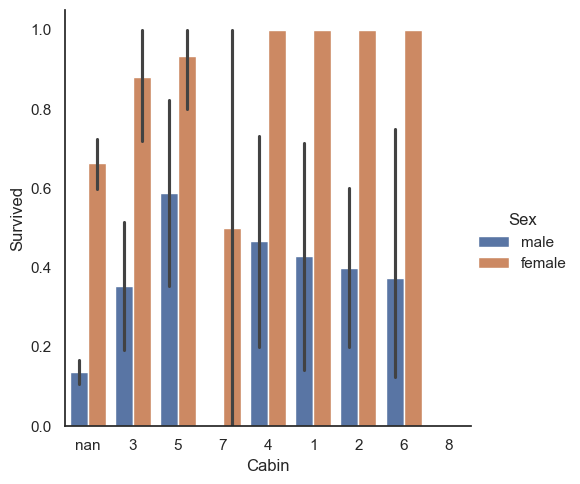

In [84]:
sns.catplot(data=combine, x='Cabin', y='Survived', hue='Sex', kind='bar')

In [85]:
combine = combine.drop(['PassengerId', 'Name', 'Cabin_letter','Ticket'],axis=1)

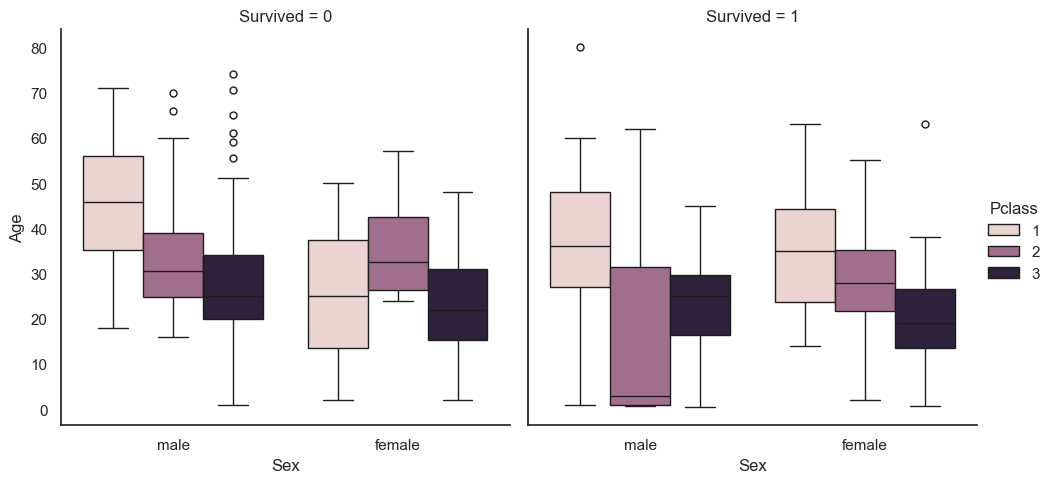

In [86]:
sns.catplot(data=train, x='Sex', y='Age', col='Survived', hue='Pclass', kind='box')

#### 6.3 Age/Pclass.

In [87]:
combine['Age'] = combine['Age'].astype(int)
combine['Pclass'] = combine['Pclass'].astype(int)

In [88]:
combine['Age/Pclass'] = combine['Age'] / combine['Pclass']

#### 6.4 Family Size and Is Alone features.

In [89]:
combine['Family_size'] = combine.SibSp + combine.Parch + 1


In [90]:
combine['Family_size'].value_counts()

Family_size
1     790
2     235
3     159
4      43
5      22
6      22
7      16
8       8
11      4
Name: count, dtype: int64

In [91]:
combine['Is_Alone'] = 0
combine.loc[combine['Family_size']==1, 'Is_Alone'] = 1
combine = combine.drop(['SibSp', 'Parch', 'Family_size'],axis=1)

In [92]:
combine['Sex'] = combine['Sex'].map({'male': 0, 'female': 1})

In [93]:
combine.head()

,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,Age/Pclass,Is_Alone
0,0.0,3,0,22,7.2500,nan,S,2,7.333333,0
1,1.0,1,1,38,71.2833,3,C,1,38.000000,0
2,1.0,3,1,26,7.9250,nan,S,1,8.666667,1
3,1.0,1,1,35,53.1000,3,S,1,35.000000,0
4,0.0,3,0,35,8.0500,nan,S,2,11.666667,1


## 7. Modeling.
* 7.1 Encoding categorical values.
* 7.2 Creating helper function to test all classifiers.
* 7.3 Applying ML models with evaluation (accuracy, f1, precision, recall).
    * Logistic Regression.
    * SVC Support Vector Machines.
    * Linear SVC.
    * SGD - Stochastic Gradient Decent.
    * K- Nearest Neigbours.
    * GNB - Gaussian Naive Base.
    * Perceptron.
    * DTC - Decision Tree CLassifier.
    * RF - Random Forest (ensable method).
    * Catboost.
    * Adaboost.
* 7.4 Compering all models.
* 7.5 Applying helper  function to test all classifiers.
* 7.6 Applying PCA, Select-K features.
* 7.7 Creating a pipeline with hyperparameter tuning selected models and cross validation.
* 7.8 Modeling with cross-validation for reference.
* 7.9 Hyperparameter tunning for 4 selected models.

##### 7.1 Encoding categorical values and creating bins for numerical.

In [94]:
combine.head()


,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,Age/Pclass,Is_Alone
0,0.0,3,0,22,7.2500,nan,S,2,7.333333,0
1,1.0,1,1,38,71.2833,3,C,1,38.000000,0
2,1.0,3,1,26,7.9250,nan,S,1,8.666667,1
3,1.0,1,1,35,53.1000,3,S,1,35.000000,0
4,0.0,3,0,35,8.0500,nan,S,2,11.666667,1


In [95]:
combine = pd.get_dummies(combine, columns=['Embarked'], prefix='Em', dtype=int)
combine = pd.get_dummies(combine, columns=['Cabin'],prefix='Cab_l',dtype=int)

In [96]:
combine.loc[combine['Fare'] <= 7.91, 'Fare'] = 0
combine.loc[(combine['Fare'] > 7.91) & (combine['Fare'] <= 14.454), 'Fare'] = 1
combine.loc[(combine['Fare'] > 14.454) & (combine['Fare'] <= 31), 'Fare']   = 2
combine.loc[combine['Fare'] > 31, 'Fare'] 							        = 3
combine['Fare'] = combine['Fare'].astype(int)

In [97]:
    # Mapping Age
combine.loc[ combine['Age'] <= 16, 'Age'] = 0
combine.loc[(combine['Age'] > 16) & (combine['Age'] <= 32), 'Age'] = 1
combine.loc[(combine['Age'] > 32) & (combine['Age'] <= 48), 'Age'] = 2
combine.loc[(combine['Age'] > 48) & (combine['Age'] <= 64), 'Age'] = 3
combine.loc[ combine['Age'] > 64, 'Age'] = 4

In [98]:
combine['Age/Pclass'] = pd.qcut(combine['Age/Pclass'], 5, labels=False)

In [99]:
combine['Age/Pclass'] = combine['Age/Pclass'].map({0: 0, 1: 1, 2: 2, 3: 3, 4: 4}).astype(int)

In [100]:
combine.head()

,Survived,Pclass,Sex,Age,Fare,Title,Age/Pclass,Is_Alone,Em_C,Em_Q,Em_S,Cab_l_1,Cab_l_2,Cab_l_3,Cab_l_4,Cab_l_5,Cab_l_6,Cab_l_7,Cab_l_8,Cab_l_nan
0,0.0,3,0,1,0,2,1,0,0,0,1,0,0,0,0,0,0,0,0,1
1,1.0,1,1,2,3,1,4,0,1,0,0,0,0,1,0,0,0,0,0,0
2,1.0,3,1,1,1,1,1,1,0,0,1,0,0,0,0,0,0,0,0,1
3,1.0,1,1,2,3,1,4,0,0,0,1,0,0,1,0,0,0,0,0,0
4,0.0,3,0,2,1,2,2,1,0,0,1,0,0,0,0,0,0,0,0,1


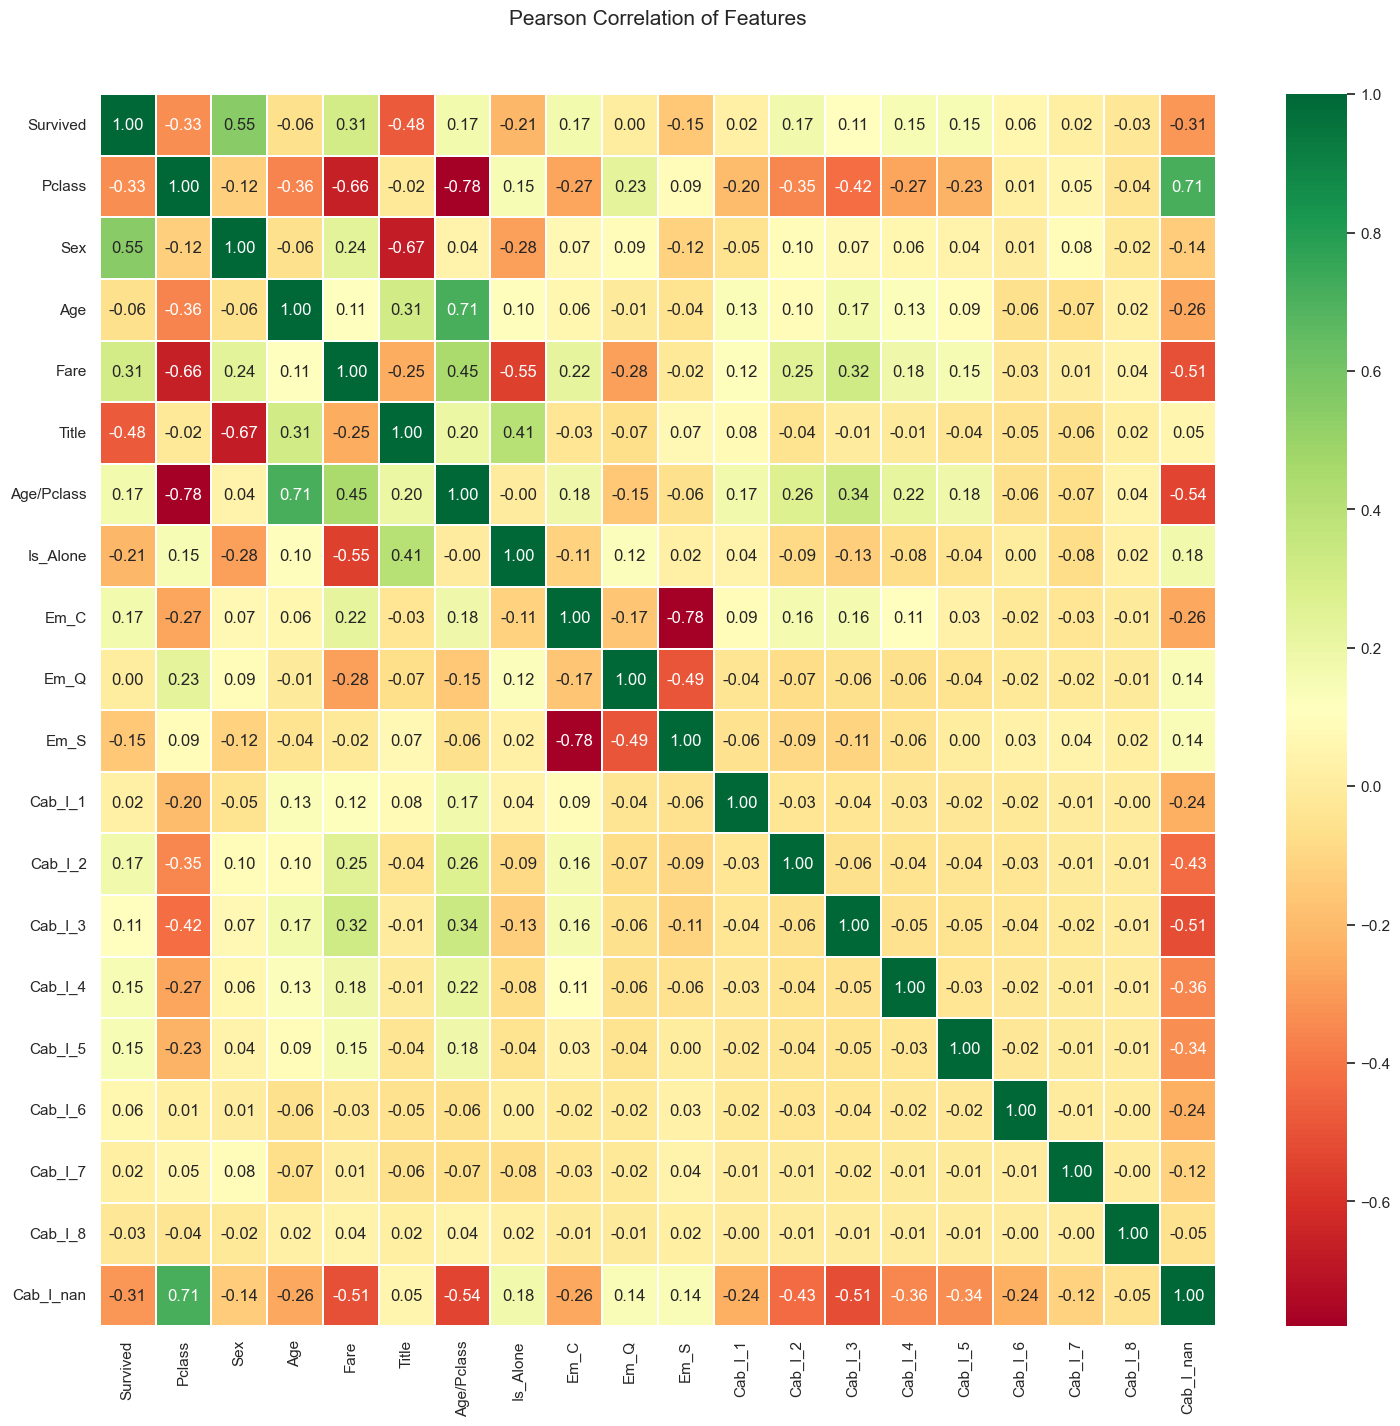

In [101]:
sns.heatmap(combine.corr(),annot=True, fmt='.2f',cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
plt.title('Pearson Correlation of Features', y=1.05, size=15)
fig.set_size_inches(18,16)
plt.show()

One thing that that the Pearson Correlation plot can tell us is that there are not too many features strongly correlated with one another. This is good from a point of view of feeding these features into your learning model because this means that there isn't much redundant or superfluous data in our training set and we are happy that each feature carries with it some unique information. Here are two most correlated features are that of Age/Class and Age.

In [102]:
train = combine[:len(train)]
test = combine[len(train):]

In [103]:
train.shape

(881, 20)

In [104]:
test.shape

(418, 20)

In [105]:
features = train.drop('Survived', axis=1)
labels = train['Survived']
s_test = test

In [106]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

#### 7.2 Creating helper function to test all classifiers.

In [107]:
from sklearn.model_selection import StratifiedShuffleSplit
PERF_FORMAT_STRING ="\tAccuracy: {:>0.{round}f}\tPrecison: {:>0.{round}f}\tRecall: {:>0.{round}f}\tF1: {:>0.{round}f}"
RESULTS_FORMAT_STRING = "\tTotal predictions: {:4d}\tTrue positives: {:4d}\tFalse positives: {:4d}\
\tFalse negatives: {:4d}\tTrue negatives: {:4d}"
def test_classifier(clf, dataset, feature_list, folds = 100):   
    labels = dataset['Survived']
    features = dataset.drop('Survived', axis=1)
    cv = StratifiedShuffleSplit(n_splits=folds, test_size=0.3, random_state=42)
    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0
    for train_idx, test_idx in cv.split(features, labels):
        train_features = features.iloc[train_idx]
        train_labels = labels.iloc[train_idx]
        test_features = features.iloc[test_idx]
        test_labels = labels.iloc[test_idx]

        clf.fit(train_features, train_labels)
        predictions = clf.predict(test_features)

        for prediction, truth in zip(predictions, test_labels):
            if prediction == 1 and truth == 1:
                true_positive+=1
            elif prediction == 0 and truth == 0:
                true_negative+=1
            elif prediction == 1 and truth == 0:
                false_positive+=1
            elif prediction == 0 and truth == 1:
                false_negative+=1

    try:
        all_predictions = true_positive + true_negative + false_positive + false_negative
        accuracy = (true_positive + true_negative) / all_predictions
        precision = true_positive / (true_positive + false_positive)
        recall = true_positive / (true_positive + false_negative)
        f1 = 2.0 * (precision * recall)  / (precision + recall)
        print("\n")
        print(clf)
        print(PERF_FORMAT_STRING.format(accuracy, precision, recall, f1, round=4))
        print(RESULTS_FORMAT_STRING.format(all_predictions, true_positive, false_positive, false_negative, true_negative))
    except ZeroDivisionError:
        print("Warning: Got a divide by zero when trying out:", clf)

### 7.3 Applying ML models with evaluation (accuracy, f1, precision, recall).

In [108]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, recall_score, precision_score
PERF_FORMAT_STRING =" \tAccuracy: {:>0.{round}f}\tF1_score: {:>0.{round}f}\tPrecision: {:>0.{round}f}\tRecall: {:>0.{round}f} "

In [109]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_acc = lr_clf.score(X_train, y_train)
lr_f1_score = f1_score(y_test, lr_pred)
lr_precision = precision_score(y_test, lr_pred)
lr_recall = recall_score(y_test, lr_pred)
print(PERF_FORMAT_STRING.format(lr_acc, lr_f1_score, lr_precision, lr_recall, round = 4))


 	Accuracy: 0.8019	F1_score: 0.7636	Precision: 0.7368	Recall: 0.7925 


In [110]:
from sklearn.svm import SVC
svc_clf = SVC()
svc_clf.fit(X_train, y_train)
svc_pred = svc_clf.predict(X_test)
svc_acc = svc_clf.score(X_train, y_train)
svc_f1_score = f1_score(y_test, svc_pred)
svc_precision = precision_score(y_test, svc_pred)
svc_recall = recall_score(y_test, svc_pred)
print(PERF_FORMAT_STRING.format(svc_acc, svc_f1_score, svc_precision, svc_recall, round = 4))

 	Accuracy: 0.7987	F1_score: 0.7281	Precision: 0.7117	Recall: 0.7453 


In [111]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors = 5)
knn_clf.fit(X_train, y_train)
knn_pred = knn_clf.predict(X_test)
knn_acc = knn_clf.score(X_train, y_train)
knn_f1_score = f1_score(y_test, knn_pred)
knn_precision = precision_score(y_test, knn_pred)
knn_recall =recall_score(y_test, knn_pred)
print(PERF_FORMAT_STRING.format(knn_acc, knn_f1_score, knn_precision, knn_recall, round = 4))

 	Accuracy: 0.8539	F1_score: 0.7200	Precision: 0.7660	Recall: 0.6792 


In [112]:
from sklearn.naive_bayes import GaussianNB
gnb_clf = GaussianNB()
gnb_clf.fit(X_train, y_train)
gnb_pred = gnb_clf.predict(X_test)
gnb_acc = gnb_clf.score(X_train, y_train)
gnb_f1_score = f1_score(y_test, gnb_pred)
gnb_precision = precision_score(y_test, gnb_pred)
gnb_recall = recall_score(y_test, gnb_pred)
print(PERF_FORMAT_STRING.format(gnb_acc, gnb_f1_score, gnb_precision, gnb_recall, round = 4))

 	Accuracy: 0.7435	F1_score: 0.6981	Precision: 0.6981	Recall: 0.6981 


In [113]:
from sklearn.linear_model import Perceptron

p_clf = Perceptron()
p_clf.fit(X_train, y_train)
p_pred = p_clf.predict(X_test)
p_acc = gnb_clf.score(X_train, y_train)
p_f1_score = f1_score(y_test, p_pred)
p_precision = precision_score(y_test, p_pred)
p_recall = recall_score(y_test, p_pred)
print(PERF_FORMAT_STRING.format(p_acc, p_f1_score, p_precision, p_recall, round = 4))

 	Accuracy: 0.7435	F1_score: 0.6667	Precision: 0.8769	Recall: 0.5377 


In [114]:
from sklearn.svm import LinearSVC
lsvc_clf = LinearSVC()
lsvc_clf.fit(X_train, y_train)
lsvc_pred = lsvc_clf.predict(X_test)
lsvc_acc = lsvc_clf.score(X_train, y_train)
lsvc_f1_score = f1_score(y_test, lsvc_pred)
lsvc_precision = precision_score(y_test, lsvc_pred)
lsvc_recall =recall_score(y_test, lsvc_pred)
print(PERF_FORMAT_STRING.format(lsvc_acc, lsvc_f1_score, lsvc_precision, lsvc_recall, round = 4))

 	Accuracy: 0.8019	F1_score: 0.7455	Precision: 0.7193	Recall: 0.7736 


In [115]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train)
sgd_pred = lsvc_clf.predict(X_test)
sgd_acc = lsvc_clf.score(X_train, y_train)
sgd_f1_score = f1_score(y_test, sgd_pred)
sgd_precision = precision_score(y_test, sgd_pred)
sgd_recall =recall_score(y_test, sgd_pred)
print(PERF_FORMAT_STRING.format(sgd_acc, sgd_f1_score, sgd_precision, sgd_recall, round = 4))

 	Accuracy: 0.8019	F1_score: 0.7455	Precision: 0.7193	Recall: 0.7736 


In [116]:
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train, y_train)
dt_pred = dt_clf.predict(X_test)
dt_acc = gnb_clf.score(X_train, y_train)
dt_f1_score = f1_score(y_test, dt_pred)
dt_precision = precision_score(y_test, dt_pred)
dt_recall = recall_score(y_test, dt_pred)
print(PERF_FORMAT_STRING.format(dt_acc, dt_f1_score, dt_precision, dt_recall, round = 4))

 	Accuracy: 0.7435	F1_score: 0.7035	Precision: 0.7527	Recall: 0.6604 


In [117]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)
rf_pred = dt_clf.predict(X_test)
rf_acc = gnb_clf.score(X_train, y_train)
rf_f1_score = f1_score(y_test, rf_pred)
rf_precision = precision_score(y_test, rf_pred)
rf_recall = recall_score(y_test, rf_pred)
print(PERF_FORMAT_STRING.format(rf_acc, rf_f1_score, rf_precision, rf_recall, round = 4))

 	Accuracy: 0.7435	F1_score: 0.7035	Precision: 0.7527	Recall: 0.6604 


In [118]:
from catboost import CatBoostClassifier
cb_clf = CatBoostClassifier()
cb_clf.fit(X_train, y_train)
cb_pred = dt_clf.predict(X_test)
cb_acc = gnb_clf.score(X_train, y_train)
cb_f1_score = f1_score(y_test, cb_pred)
cb_precision = precision_score(y_test, cb_pred)
cb_recall = recall_score(y_test, cb_pred)
print(PERF_FORMAT_STRING.format(cb_acc, cb_f1_score, cb_precision, cb_recall, round = 4))

Learning rate set to 0.008377
0:	learn: 0.6878672	total: 136ms	remaining: 2m 15s
1:	learn: 0.6825996	total: 138ms	remaining: 1m 8s
2:	learn: 0.6767935	total: 140ms	remaining: 46.5s
3:	learn: 0.6713471	total: 141ms	remaining: 35.2s
4:	learn: 0.6661561	total: 143ms	remaining: 28.4s
5:	learn: 0.6613598	total: 145ms	remaining: 24s
6:	learn: 0.6566163	total: 147ms	remaining: 20.8s
7:	learn: 0.6514956	total: 148ms	remaining: 18.4s
8:	learn: 0.6471065	total: 150ms	remaining: 16.5s
9:	learn: 0.6421060	total: 152ms	remaining: 15s
10:	learn: 0.6378541	total: 154ms	remaining: 13.8s
11:	learn: 0.6348342	total: 155ms	remaining: 12.7s
12:	learn: 0.6301003	total: 156ms	remaining: 11.9s
13:	learn: 0.6253180	total: 158ms	remaining: 11.1s
14:	learn: 0.6213008	total: 160ms	remaining: 10.5s
15:	learn: 0.6167999	total: 161ms	remaining: 9.91s
16:	learn: 0.6123721	total: 163ms	remaining: 9.42s
17:	learn: 0.6090965	total: 164ms	remaining: 8.95s
18:	learn: 0.6051861	total: 166ms	remaining: 8.55s
19:	learn: 0.6

In [119]:
from sklearn.ensemble import AdaBoostClassifier
ab_clf = AdaBoostClassifier()
ab_clf.fit(X_train, y_train)
ab_pred = dt_clf.predict(X_test)
ab_acc = gnb_clf.score(X_train, y_train)
ab_f1_score = f1_score(y_test, ab_pred)
ab_precision = precision_score(y_test, ab_pred)
ab_recall = recall_score(y_test, ab_pred)
print(PERF_FORMAT_STRING.format(ab_acc, ab_f1_score, ab_precision, ab_recall, round = 4))

 	Accuracy: 0.7435	F1_score: 0.7035	Precision: 0.7527	Recall: 0.6604 


In [120]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

In [121]:
classifiers = []
classifiers.append(LogisticRegression())
classifiers.append(SVC())
classifiers.append(KNeighborsClassifier(n_neighbors = 5))
classifiers.append(GaussianNB())
classifiers.append(Perceptron())
classifiers.append(LinearSVC())
classifiers.append(SGDClassifier())
classifiers.append(DecisionTreeClassifier())
classifiers.append(RandomForestClassifier())
classifiers.append(CatBoostClassifier())
classifiers.append(AdaBoostClassifier())

cv1_results = []

for classifier in classifiers:
    cv1_results.append(cross_val_score(classifier, X_train, y = y_train, scoring = "accuracy", cv = kfold))
    
cv1_mean = []
cv1_std = []

for result in cv1_results:
    cv1_mean.append(result.mean())
    cv1_std.append(result.std())

cv1_res = pd.DataFrame({'Cross Validation Mean': cv1_mean, 'Cross Validation Std': cv1_std, 'Algorithm': ['Logistic Regression', 'Support Vector Machines', 'K-Nearest Neighbours','Gausian Naive Bayes','Perceptron', 'Linear SVC','Stochastic gradnient descent', 'Decision tree', 'Random Forest','CatBoost', 'AdaBoost']})




Learning rate set to 0.008006
0:	learn: 0.6881922	total: 1.43ms	remaining: 1.43s
1:	learn: 0.6838313	total: 2.69ms	remaining: 1.34s
2:	learn: 0.6787346	total: 4.11ms	remaining: 1.36s
3:	learn: 0.6742195	total: 5.6ms	remaining: 1.4s
4:	learn: 0.6692892	total: 7.03ms	remaining: 1.4s
5:	learn: 0.6647569	total: 8.38ms	remaining: 1.39s
6:	learn: 0.6598053	total: 9.78ms	remaining: 1.39s
7:	learn: 0.6550706	total: 11.1ms	remaining: 1.38s
8:	learn: 0.6510628	total: 12.5ms	remaining: 1.38s
9:	learn: 0.6478668	total: 13.8ms	remaining: 1.36s
10:	learn: 0.6442336	total: 14.9ms	remaining: 1.34s
11:	learn: 0.6398405	total: 16.3ms	remaining: 1.34s
12:	learn: 0.6351166	total: 17.7ms	remaining: 1.34s
13:	learn: 0.6308831	total: 19.1ms	remaining: 1.34s
14:	learn: 0.6265560	total: 20.5ms	remaining: 1.34s
15:	learn: 0.6240934	total: 21.7ms	remaining: 1.33s
16:	learn: 0.6205751	total: 23.2ms	remaining: 1.34s
17:	learn: 0.6167259	total: 24.6ms	remaining: 1.34s
18:	learn: 0.6126330	total: 25.9ms	remaining: 1

#### 7.4 Compering all models

In [122]:
models = pd.DataFrame({'Model': ['Logistic Regression', 'SVC Support Vector Machines', 'Linear SVC', 'SGD - Stochastic Gradient Decent',
                       'K- Nearest Neigbours', 'GNB - Gaussian Naive Base', 'Perceptron', 'DTC - Decision Tree CLassifier',
                       'RF - Random Forest', 'Catboost', 'Adaboost'],
                      'Accuracy': [lr_acc, svc_acc, lsvc_acc, sgd_acc, knn_acc, gnb_acc, p_acc, dt_acc, rf_acc, cb_acc, ab_acc],
                      'F1':[ lr_f1_score, svc_f1_score, lsvc_f1_score, sgd_f1_score, knn_f1_score, gnb_f1_score, p_f1_score, dt_f1_score, rf_f1_score,
                       cb_f1_score, ab_f1_score],
                      'Precision': [lr_precision, svc_precision, lsvc_precision, sgd_precision, knn_precision, gnb_precision, p_precision, 
                       dt_precision, rf_precision, cb_precision, ab_precision],
                      'Recall':[ lr_recall, svc_recall, lsvc_recall, sgd_recall, knn_recall, gnb_recall, p_recall, dt_recall, rf_recall,
                       cb_recall, ab_recall ]}
                     )
models.sort_values('F1', ascending=False)

,Model,Accuracy,F1,Precision,Recall
0,Logistic Regression,0.801948,0.763636,0.736842,0.792453
2,Linear SVC,0.801948,0.745455,0.719298,0.773585
3,SGD - Stochastic Gradient Decent,0.801948,0.745455,0.719298,0.773585
1,SVC Support Vector Machines,0.798701,0.728111,0.711712,0.745283
4,K- Nearest Neigbours,0.853896,0.720000,0.765957,0.679245
7,DTC - Decision Tree CLassifier,0.743506,0.703518,0.752688,0.660377
8,RF - Random Forest,0.743506,0.703518,0.752688,0.660377
9,Catboost,0.743506,0.703518,0.752688,0.660377
10,Adaboost,0.743506,0.703518,0.752688,0.660377
5,GNB - Gaussian Naive Base,0.743506,0.698113,0.698113,0.698113


In [123]:
cv1_res.head().sort_values(by='Cross Validation Mean', ascending=False)

,Cross Validation Mean,Cross Validation Std,Algorithm
1,0.796801,0.056032,Support Vector Machines
2,0.795373,0.067122,K-Nearest Neighbours
0,0.777525,0.042657,Logistic Regression
4,0.728794,0.131774,Perceptron
3,0.709334,0.052989,Gausian Naive Bayes


#### 7.5 Applying helper function to test top 3 classifiers.

In [124]:
features_list = X_train
test_classifier(classifiers[1], train, features_list)



SVC()
 	Accuracy: 0.8049	F1_score: 0.7577	Precision: 0.7249	Recall: 0.7410 
	Total predictions: 26500	True positives: 7394	False positives: 2364	False negatives: 2806	True negatives: 13936


In [125]:
test_classifier(classifiers[2], train, features_list)



KNeighborsClassifier()
 	Accuracy: 0.7966	F1_score: 0.7672	Precision: 0.6771	Recall: 0.7193 
	Total predictions: 26500	True positives: 6906	False positives: 2096	False negatives: 3294	True negatives: 14204


In [126]:
test_classifier(classifiers[0], train, features_list)



LogisticRegression()
 	Accuracy: 0.7980	F1_score: 0.7332	Precision: 0.7470	Recall: 0.7400 
	Total predictions: 26500	True positives: 7619	False positives: 2773	False negatives: 2581	True negatives: 13527


#### 7.6 Applying PCA, Select-KFeatures techniques

In [127]:
from sklearn.decomposition import PCA
pca = PCA(n_components=8)
X_train_pca = pca.fit_transform(X_train)
print(pca.explained_variance_ratio_)
pca_components = pca.components_
first_pca = pca.components_[0]



[0.51309791 0.21870187 0.06275558 0.0510182  0.04814219 0.0206832
 0.01823761 0.01614834]


In [128]:
features.shape

(881, 19)

In [129]:
features_list = features.columns

In [130]:
from sklearn.feature_selection import SelectKBest, f_classif
kbest = SelectKBest(f_classif, k=10)
kbest.fit_transform(X_train, y_train)

selected_features_indices = kbest.get_support(indices=True)
features_selected = [features_list[i] for i in selected_features_indices]
features_selected

['Pclass',
 'Sex',
 'Fare',
 'Title',
 'Age/Pclass',
 'Is_Alone',
 'Em_C',
 'Em_S',
 'Cab_l_4',
 'Cab_l_nan']

In [131]:
test_classifier(lr_clf, train, features_selected)



LogisticRegression()
 	Accuracy: 0.7980	F1_score: 0.7332	Precision: 0.7470	Recall: 0.7400 
	Total predictions: 26500	True positives: 7619	False positives: 2773	False negatives: 2581	True negatives: 13527


#### 7.7 Creating a pipeline with hyperparameter tuning for selected models and cross validation.

In [132]:
# from sklearn.pipeline import Pipeline
# from sklearn.model_selection import GridSearchCV
# select = SelectKBest()
# lr = LogisticRegression()


# steps = [('feature_select', select),
#          ('classifier', lr)]

# param_grid = {'feature_select__k': [4, 8, 12],
#              'classifier__C': [0.001, 0.1, 1, 10],
#              'classifier__penalty': ['l1', 'l2'],
#              'classifier__solver': ['liblinear', 'lbfgs', ],
#              'classifier__class_weight': [None, 'balanced'],
#              'classifier__multi_class': ['ovr', 'multinomial'],
#              'classifier__tol': [1e-4, 1e-3],
#              'classifier__max_iter': [100, 1000],
#              'classifier__warm_start': [True, False]}
# sss = StratifiedShuffleSplit(100, test_size=0.3, random_state=43)
# pipe = Pipeline(steps)
# gs = GridSearchCV(pipe, param_grid, cv=sss, scoring='f1')
# gs.fit(X_train, y_train)
# clf = gs.best_estimator_
# gs.best_score_

In [133]:
# test_classifier(clf, train, features_selected)

##### The best parameters for Logistic Regression found by SearchGridCV:
Pipeline(steps=[('feature_select', SelectKBest(k=2)),
                ('classifier',
                 LogisticRegression(C=0.001, class_weight='balanced',
                 multi_class='ovr', solver='liblinear',
                 warm_start=True))])

GridSearchCV results: 
* Accuracy: 0.7868	
* Precison: 0.7077	
* Recall: 0.7601	
* F1: 0.7329

The results before gridsearchcv:
* acc: 0.819805
* precision:0.781818
* recall: 0.754386
* f1: 0.811321

The results of hyperparamter tunning are for some reason worse than before. It mightbe due to narrowing down the parameters befeore running the GridsearchCV due to cpu performance issued. For some reason I can't use multiple cores and I'm unable to manage full GridSearch with just one core.
We will omit those results for now.

#### 7.8 Modeling with cross-validation for reference.

In [134]:
# Modeling step with cross validation to Test differents algorithms 
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []

for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y_train, scoring = "accuracy", cv = kfold))
    
cv_means = []
cv_std = []

for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({'Cross Validation Mean':cv_means,'Cross Validation Std': cv_std,'Algorithm':["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})



In [135]:
cv_res.head(10).sort_values(by='Cross Validation Mean', ascending=False)

,Cross Validation Mean,Cross Validation Std,Algorithm
4,0.806769,0.061426,ExtraTrees
2,0.805050,0.072410,AdaBoost
5,0.803543,0.067727,GradientBoosting
3,0.803437,0.066740,RandomForest
1,0.798572,0.068621,DecisionTree
0,0.796801,0.056032,SVC
7,0.795373,0.067122,KNeighboors
9,0.785590,0.038949,LinearDiscriminantAnalysis
6,0.777631,0.041369,MultipleLayerPerceptron
8,0.777525,0.042657,LogisticRegression


<Axes: xlabel='Cross Validation Mean', ylabel='Algorithm'>

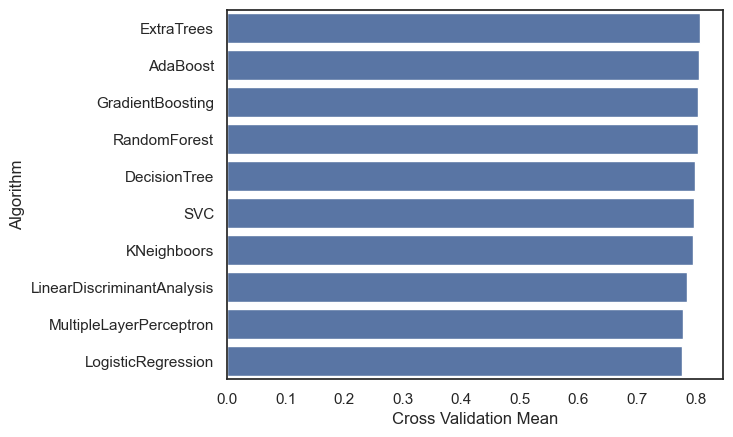

In [136]:
sns.barplot(data=cv_res, x='Cross Validation Mean', y='Algorithm', order=cv_res.sort_values(by='Cross Validation Mean', ascending=False)['Algorithm'])


#### 7.9 Hyperparameter tunning for 4 best models.
 AdaBoost, ExtraTrees , RandomForest, GradientBoosting and SVl on 4 cpu.

In [137]:
# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", verbose = 1)

gsadaDTC.fit(X_train,y_train)

ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


In [138]:
gsadaDTC.best_score_

0.8083818085668957

In [139]:
#ExtraTrees 
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", verbose = 1)

gsExtC.fit(X_train,y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_


Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8196721311475409

In [140]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", verbose = 1)

gsRFC.fit(X_train,y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8228979375991539

In [141]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance", "exponential"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", verbose = 1)

gsGBC.fit(X_train,y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_


Fitting 10 folds for each of 144 candidates, totalling 1440 fits


0.8099947117927023

In [142]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", verbose = 1)

gsSVMC.fit(X_train,y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


0.8132469592808038

#### 7.10 Plot learning curves

Learning curves are a good way to see the overfitting effect on the training set and the effect of the training size on the accuracy.

In [143]:
train_scores = np.array([[0.8, 0.85, 0.88],
       [0.75, 0.82, 0.87],
       [0.72, 0.80, 0.86],
       [0.70, 0.78, 0.85],
       [0.68, 0.75, 0.84]])
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_mean

array([0.84333333, 0.81333333, 0.79333333, 0.77666667, 0.75666667])

In [144]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt



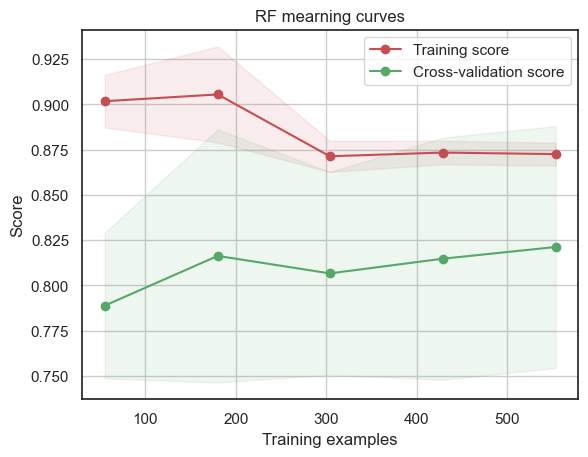

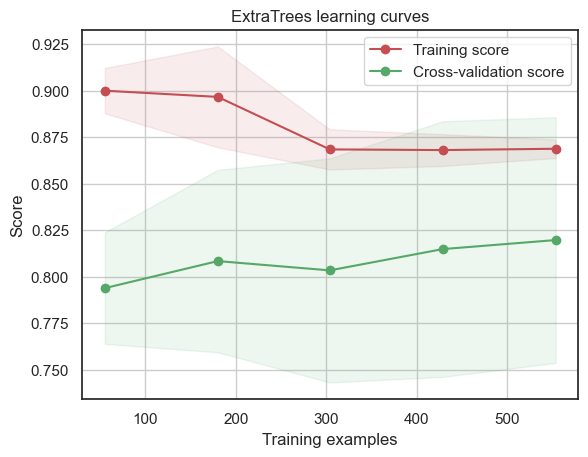

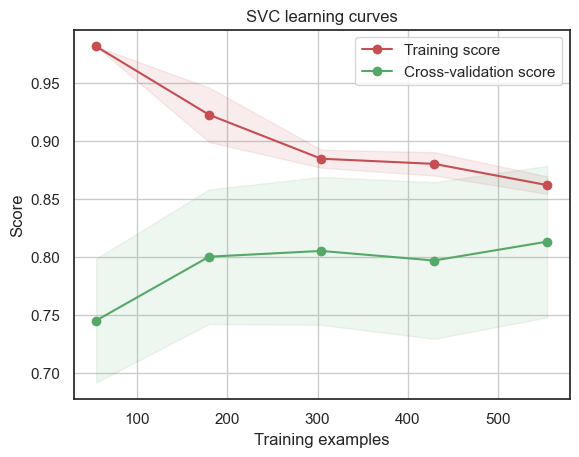

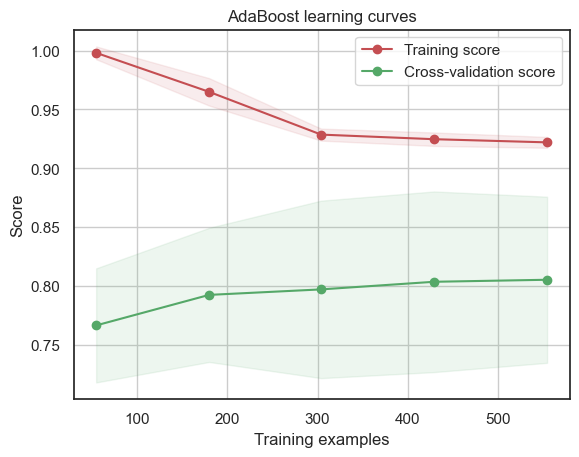

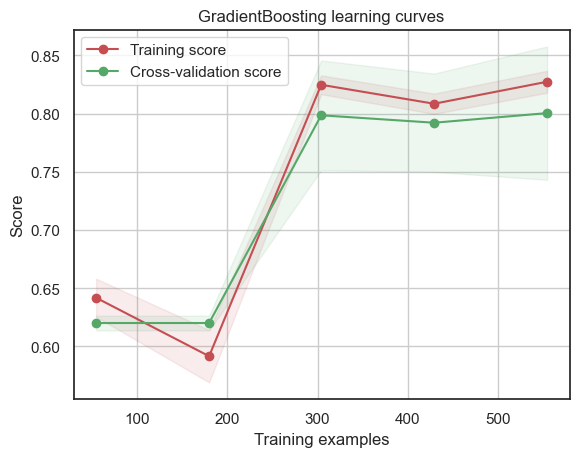

In [145]:
g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,y_train,cv=kfold)

SVC and Adaboost classifiers tend to overfit the training set. According to the growing cross-validation curves GradientBoosting, Adaboost SVC  and ExtraTrees could perform better with more training examples.
GradientBoostinges classifrrs seem to better generalize the prediction since the training and cross-validation curves are close together.

#### 7.11 Feature importance of tree based classifiers.

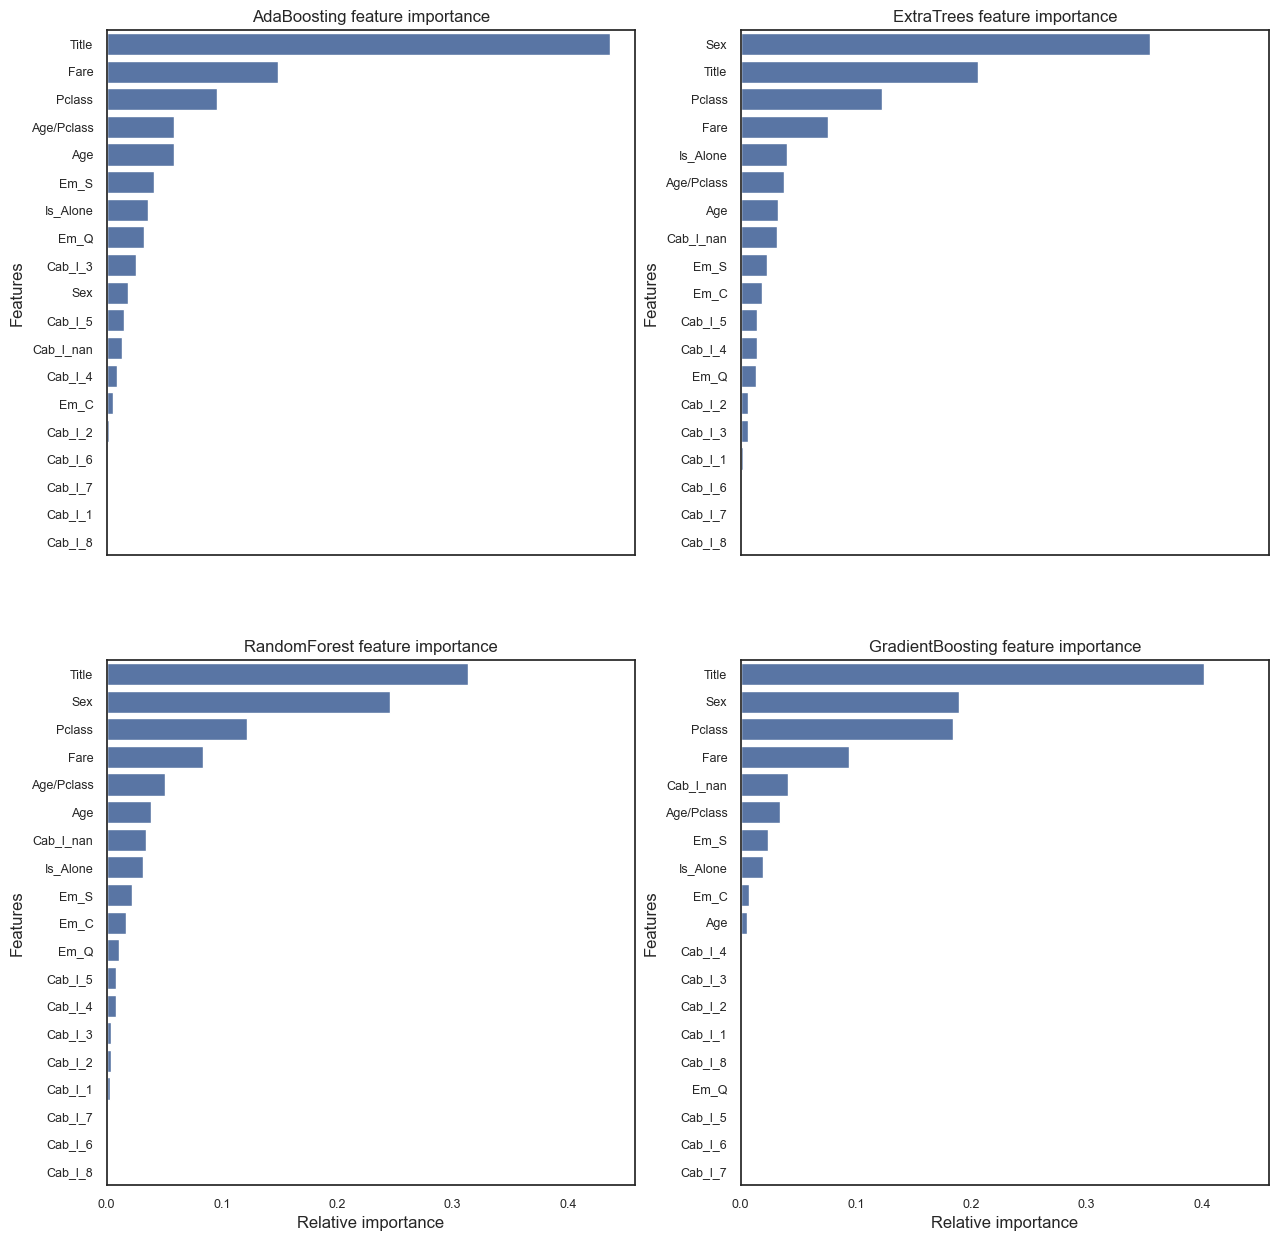

In [146]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:20]
        g = sns.barplot(y=X_train.columns[indices][:20],x = classifier.feature_importances_[indices][:20] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

In [147]:
test.drop(labels=["Survived"],axis = 1,inplace=True)
test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")

ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC, test_Survived_SVMC],axis=1)
ensemble_results

,RFC,ExtC,Ada,GBC,SVC
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
413,0.0,0.0,0.0,0.0,0.0
414,1.0,1.0,0.0,1.0,1.0
415,0.0,0.0,0.0,0.0,0.0
416,0.0,0.0,0.0,0.0,0.0


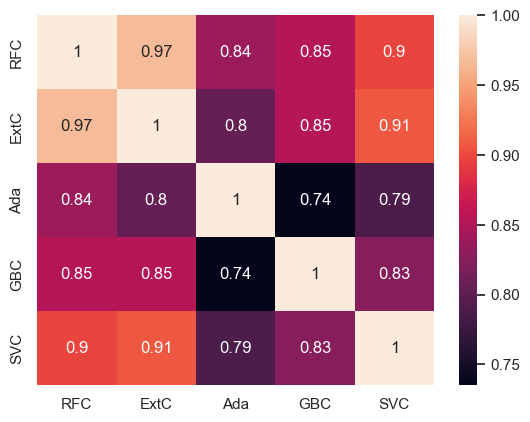

In [148]:
g= sns.heatmap(ensemble_results.corr(),annot=True)

 prediction seems to be quite similar for the 5 classifiers.

The 5 classifiers give more or less the same prediction but there are some differences. 
Theses differences between the 5 classifier predictions are sufficient to consider an ensembling vote. 

### 7.12 Ensemble modeling.
I choosed a voting classifier to combine the predictions coming from the 5 classifiers.

In [149]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=1)

votingC = votingC.fit(X_train, y_train)

### 8. Prediction.
#### 8.1 Predict and Submit results.

In [150]:
test_survived = pd.Series(votingC.predict(test), name='Survived')
test_survived

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
413    0.0
414    1.0
415    0.0
416    0.0
417    1.0
Name: Survived, Length: 418, dtype: float64

In [153]:
results = pd.concat([testId, test_survived],axis=1)

results.to_csv('Submit.csv', index=False)

,PassengerId,Survived
0,892,0.0
1,893,0.0
2,894,0.0
3,895,0.0
4,896,0.0
...,...,...
413,1305,0.0
414,1306,1.0
415,1307,0.0
416,1308,0.0
